In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import random

from itertools import product

from datetime import datetime, timedelta

from feature_engine.creation import CyclicalFeatures
from feature_engine.creation import RelativeFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import LagFeatures
from feature_engine.timeseries.forecasting import WindowFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline

from sktime.split import temporal_train_test_split
from sktime.utils import plotting

from statistics import mean 
from statistics import stdev

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

# Previsão da geração de energia elétrica para o Conjunto Eólico Umburanas

Horizonte de previsão: 36 horas no futuro

Dados de entrada:
- Histórico de geração verificada horária
- Histórico da velocidade do vento, com granularidade horária

Algoritmos de aprendizagem de máquina utilizados:
- Regressão linear regularizada "_ridge_"
- Floresta aleatória
- Regressor "_Light Gradient Boosted Machine_" (_LightGBM_)
- Regressor "_Extreme Gradient Boosted_" (_XGBoost_)

Técnicas de ajuste de hiperparâmetros utilizadas:
- Busca em grade
- Busca aleatória

Métrica de desempenho:
- Raiz do erro quadrático médio

Técnicas de estimação de desempenho e validação cruzada:
- Validação cruzada para séries temporais

Parâmetro de comparação:
- Curva de geração programada pelo Operador Nacional do Sistema

## Leitura e tratamento de dados

In [2]:
# Lendo dados de geração em usinas eólicas
df_umburanas = pd.read_csv(r"..\Dados tratados\geracao e tempo - umburanas-ba.csv")

### Conjunto Umburanas - Bahia

In [3]:
df_umburanas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24816 entries, 0 to 24815
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Data                24816 non-null  object 
 1   Geração programada  24816 non-null  float64
 2   Geração verificada  24816 non-null  float64
 3   temperatura         24816 non-null  float64
 4   velocidade_vento    24816 non-null  float64
 5   direcao_vento       24816 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
# Fonte: Feature Engineering for Time Series Forecasting, https://www.trainindata.com/
df_umburanas["Data"] = pd.to_datetime(df_umburanas["Data"], format="%Y-%m-%d %H:%M:%S")
df_umburanas = df_umburanas.set_index("Data")
df_umburanas.sort_index(inplace=True)
df_umburanas = df_umburanas.asfreq("1h", method = "ffill")
df_umburanas.head(20)

,Geração programada,Geração verificada,temperatura,velocidade_vento,direcao_vento
Data,,,,,
2021-01-01 00:00:00,257.5,291.246,20.5,23.2,83
2021-01-01 01:00:00,234.5,297.211,19.9,26.3,100
2021-01-01 02:00:00,221.0,286.336,18.9,25.6,92
2021-01-01 03:00:00,206.0,266.143,18.2,25.6,92
2021-01-01 04:00:00,187.5,262.873,17.9,24.5,93
2021-01-01 05:00:00,171.0,246.994,17.9,24.2,93
2021-01-01 06:00:00,163.5,222.862,18.2,24.2,94
2021-01-01 07:00:00,163.5,254.567,19.4,24.9,92
2021-01-01 08:00:00,161.0,221.275,21.0,24.1,91


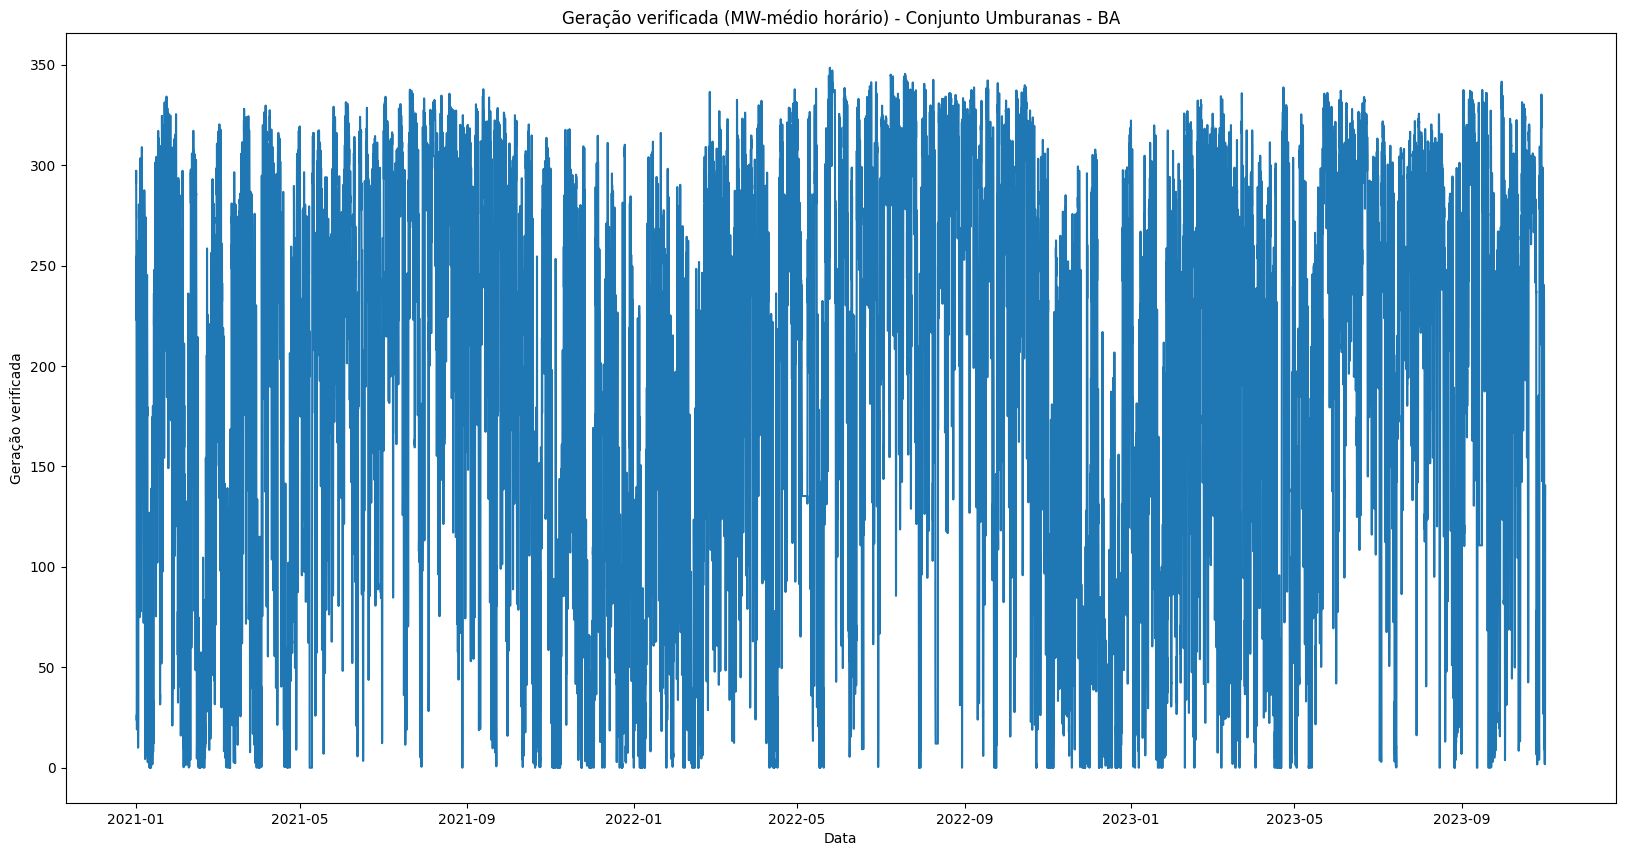

In [5]:
fig, axes = plt.subplots(figsize=(20,10))
sns.lineplot(data=df_umburanas,
             x="Data", y="Geração verificada",
             ax=axes);
axes.set_title("Geração verificada (MW-médio horário) - Conjunto Umburanas - BA");

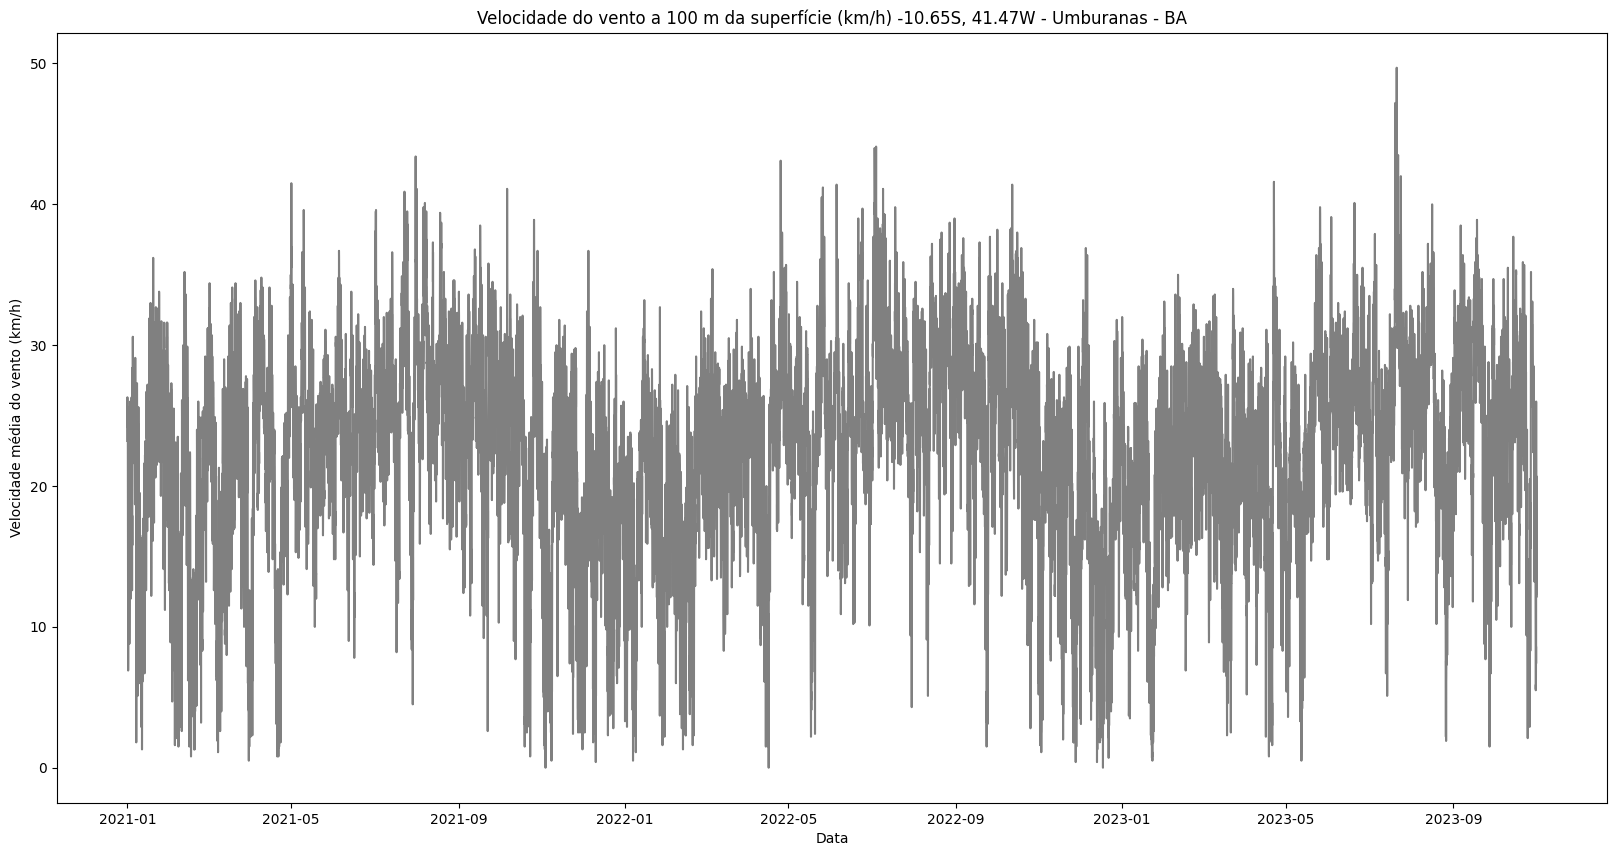

In [6]:
fig, axes = plt.subplots(figsize=(20,10))
sns.lineplot(data=df_umburanas,
             x="Data", y="velocidade_vento",
             ax=axes,
            color="grey");
axes.set_title("Velocidade do vento a 100 m da superfície (km/h) -10.65S, 41.47W - Umburanas - BA");
axes.set_xlabel("Data");
axes.set_ylabel("Velocidade média do vento (km/h)");

## Previsão da geração de energia

### Criação de parâmetros para o treinamento de modelos de previsão

In [7]:
df=df_umburanas.copy()
df.rename(columns={"velocidade_vento":"vento_t",
                   "Geração verificada":"g_ver_t",
                   "Geração programada":"g_prog_t"
                  },inplace=True)


baseline = pd.DataFrame(df[["g_prog_t"]])
df.drop(["g_prog_t"], axis=1, inplace=True)
df = df[["vento_t","g_ver_t"]]
df.tail()

,vento_t,g_ver_t
Data,,
2023-10-31 19:00:00,12.3,2.664
2023-10-31 20:00:00,17.9,3.898
2023-10-31 21:00:00,12.1,62.861
2023-10-31 22:00:00,20.7,102.989
2023-10-31 23:00:00,17.8,140.451


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24816 entries, 2021-01-01 00:00:00 to 2023-10-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   vento_t  24816 non-null  float64
 1   g_ver_t  24816 non-null  float64
dtypes: float64(2)
memory usage: 581.6 KB


In [9]:
# Construção de atributos preditivos

# Adaptado do material disponível no curso "Feature engineering for time series forecasting"
# https://github.com/trainindata/feature-engineering-for-time-series-forecasting/tree/main/03-Challenges-in-Time-Series-Forecasting

# Atributos temporais
atributos_temporais = DatetimeFeatures(variables="index",features_to_extract=["month","hour"])

# Atributos de atraso
atributos_atraso = LagFeatures(variables=["g_ver_t","vento_t"], freq = ["1H","2H","12H","24H","36H"], missing_values="ignore")

# Atributos agregados em janelas
atributos_media_movel = WindowFeatures(variables=["g_ver_t","vento_t"],functions=["mean"], window = ["3H","6H","24H","36H"],
                                 freq="1H", missing_values = "ignore")

# Atributos cíclicos relacionados à sazonalidade
atributos_ciclicos = CyclicalFeatures(variables=["month","hour"], drop_original=True)

# Atributos subtrativos
atributos_subtrativos_g = RelativeFeatures(variables=["g_ver_t_lag_1H"], reference=["g_ver_t_lag_2H"], func=["sub"])
atributos_subtrativos_v = RelativeFeatures(variables=["vento_t_lag_1H"], reference=["vento_t_lag_24H"], func=["sub"])

# Remoção de dados faltantes
remocao_faltantes = DropMissingData()

# Remoção dos atributos originais (isto é, atributos a serem previstos)
remocao_de_atributos = DropFeatures(features_to_drop=["g_ver_t","vento_t"])

pipeline = Pipeline(
    [
        
        ("normalizador", SklearnTransformerWrapper(
           transformer = StandardScaler(),
          variables = ["g_ver_t","vento_t"]
         )
        ),
        ("atributos_temporais", atributos_temporais),
        ("atributos_atraso", atributos_atraso),
        ("atributos_media_movel", atributos_media_movel),
        ("atributos_ciclicos", atributos_ciclicos),
        ("remocao_faltantes", remocao_faltantes),
        ("atributos_subtrativos_g", atributos_subtrativos_g),
        ("atributos_subtrativos_v", atributos_subtrativos_v),
        ("remocao_de_atributos", remocao_de_atributos)
    ]

)

In [10]:
pipeline

Pipeline(steps=[('normalizador',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['g_ver_t', 'vento_t'])),
                ('atributos_temporais',
                 DatetimeFeatures(features_to_extract=['month', 'hour'],
                                  variables='index')),
                ('atributos_atraso',
                 LagFeatures(freq=['1H', '2H', '12H', '24H', '36H'],
                             missing_values='ignore',
                             variables=['g_ver_t', 'vento_t'])),
                ('atrib...
                ('remocao_faltantes', DropMissingData()),
                ('atributos_subtrativos_g',
                 RelativeFeatures(func=['sub'], reference=['g_ver_t_lag_2H'],
                                  variables=['g_ver_t_lag_1H'])),
                ('atributos_subtrativos_v',
                 RelativeFeatures(func=['sub'], reference=['vento_t_lag_24H'],
                                  variables=['vento_t_lag_1H'])),
                ('remocao_de_atributos',
                 DropFeatures(features_to_drop=['g_ver_t', 'vento_t']))])

### Divisão do conjunto de dados em um conjunto para treinamento e outro para teste

Criação de seis conjuntos de dados, sendo cada um deles dividido em um conjunto para treinamento e outro para teste:
- Conjunto #1: Treinamento: de 01/01/2021 a 30/06/2021; Teste: a partir de 01/07/2021
- Conjunto #2: Treinamento: de 01/01/2021 a 31/12/2021; Teste: a partir de 01/01/2022
- Conjunto #3: Treinamento: de 01/01/2021 a 30/06/2022; Teste: a partir de 01/07/2022
- Conjunto #4: Treinamento: de 01/01/2021 a 31/12/2022; Teste: a partir de 01/01/2023
- Conjunto #5: Treinamento: de 01/01/2021 a 30/06/2023; Teste: a partir de 01/07/2023
- Conjunto #6: Treinamento: de 01/01/2021 a 30/09/2023; Teste: a partir de 01/10/2023

In [11]:
train_cutoff_dates = ["2021-03-31","2021-06-30","2021-09-30","2021-12-31",
                      "2022-03-31","2022-06-30","2022-09-30","2022-12-31",
                      "2023-03-31","2023-06-30","2023-09-30"]

In [12]:
# Adaptado do material disponível no curso "Feature engineering for time series forecasting"
# https://github.com/trainindata/feature-engineering-for-time-series-forecasting/tree/main/03-Challenges-in-Time-Series-Forecasting

def split_train_test(dataset, cutoff_date, forecast_horizon = 36, target_variables=[]):
    test_start_date = pd.to_datetime(cutoff_date) - timedelta(hours = forecast_horizon)
    X_train, X_test = dataset[dataset.index < cutoff_date] , dataset[dataset.index >= test_start_date]
    
    if len(target_variables)== 0:
        print("Erro: não foram indicadas as variáveis a serem previstas.")
        return
    else:
        y_train, y_test = dataset[dataset.index < cutoff_date][target_variables], dataset[dataset.index >= test_start_date][target_variables]
        return (X_train, X_test, y_train, y_test)
        
def split_baseline_dataset(baseline_df, cutoff_date, forecast_horizon = 36, baseline_variables=[]):
    test_start_date = pd.to_datetime(cutoff_date) - timedelta(hours = forecast_horizon)
    if len(baseline_variables)== 0:
        print("Erro: não foram indicadas as variáveis de base a servirem de comparação.")
        return
    else:
        baseline_train, baseline_test = baseline_df[baseline_df.index < cutoff_date][baseline_variables], baseline_df[baseline_df.index >= test_start_date][baseline_variables]
        return(baseline_train, baseline_test)

In [13]:
X_train, X_test, y_train, y_test = split_train_test(dataset = df, 
                                                    cutoff_date = "2023-10-01", 
                                                    forecast_horizon = 36, 
                                                    target_variables=["vento_t","g_ver_t"])

baseline_train, baseline_test = split_baseline_dataset(baseline_df = baseline, 
                                                       cutoff_date = "2023-10-01",
                                                       forecast_horizon = 36, 
                                                       baseline_variables = ["g_prog_t"])

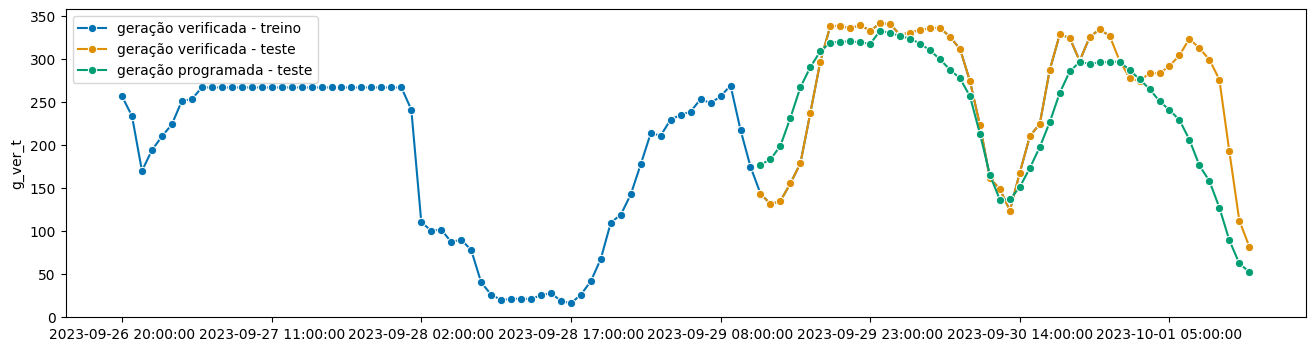

In [14]:
fig, axes = plotting.plot_series(y_train[-100:]["g_ver_t"], y_test[:50]["g_ver_t"], baseline_test[:50], labels = ["geração verificada - treino", "geração verificada - teste", "geração programada - teste"])

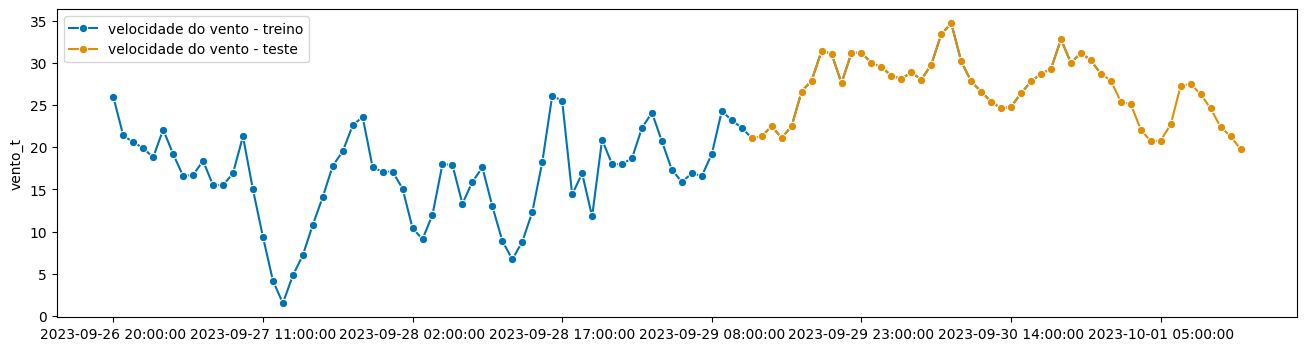

In [15]:
fig, axes = plotting.plot_series(y_train[-100:]["vento_t"], y_test[:50]["vento_t"], labels = ["velocidade do vento - treino", "velocidade do vento - teste"])

In [16]:
def transform_features_train_set(pipeline, X_train, y_train):
    X_train = pipeline.fit_transform(X_train)
    train_indices = X_train.index
    y_train = y_train.loc[train_indices]
    return(X_train, y_train)

In [17]:
X_train_transformed, y_train_transformed = transform_features_train_set(pipeline, X_train, y_train)
X_train_transformed

,g_ver_t_lag_1H,vento_t_lag_1H,g_ver_t_lag_2H,vento_t_lag_2H,g_ver_t_lag_12H,vento_t_lag_12H,g_ver_t_lag_24H,vento_t_lag_24H,g_ver_t_lag_36H,vento_t_lag_36H,...,g_ver_t_window_24H_mean,vento_t_window_24H_mean,g_ver_t_window_36H_mean,vento_t_window_36H_mean,month_sin,month_cos,hour_sin,hour_cos,g_ver_t_lag_1H_sub_g_ver_t_lag_2H,vento_t_lag_1H_sub_vento_t_lag_24H
Data,,,,,,,,,,,,,,,,,,,,,
2021-01-02 12:00:00,-1.774180,-1.767187,-1.752294,-1.107546,0.023593,-0.251417,-1.642152,-1.809292,0.951027,0.113491,...,-0.668700,-0.815152,-0.359753,-0.524318,0.5,8.660254e-01,-1.361666e-01,-0.990686,-0.021887,0.042105
2021-01-02 13:00:00,-1.732713,-1.907536,-1.774180,-1.767187,0.442679,0.001212,-1.614675,-1.935606,1.008820,0.548573,...,-0.672473,-0.819246,-0.434301,-0.580457,0.5,8.660254e-01,-3.984011e-01,-0.917211,0.041468,0.028070
2021-01-02 14:00:00,-1.614413,-1.739117,-1.732713,-1.907536,0.125770,0.155596,-1.686342,-2.174199,0.903455,0.450329,...,-0.672462,-0.811059,-0.507169,-0.644004,0.5,8.660254e-01,-6.310879e-01,-0.775711,0.118299,0.435082
2021-01-02 15:00:00,-1.585890,-1.528593,-1.614413,-1.739117,-0.092536,0.071386,-1.678010,-2.104025,0.707811,0.450329,...,-0.668277,-0.784159,-0.576317,-0.698974,0.5,8.660254e-01,-8.169699e-01,-0.576680,0.028524,0.575431
2021-01-02 16:00:00,-0.759024,-1.275965,-1.585890,-1.528593,0.032923,-0.153172,-1.523233,-1.907536,0.676129,0.295945,...,-0.629986,-0.749656,-0.617063,-0.746927,0.5,8.660254e-01,-9.422609e-01,-0.334880,0.826865,0.631571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-30 19:00:00,1.312078,0.969620,0.913628,0.885411,1.284077,1.545051,1.407453,1.264353,0.538810,-0.812813,...,0.881346,0.921668,0.621516,0.614069,-1.0,-1.836970e-16,-8.878852e-01,0.460065,0.398449,-0.294733
2023-09-30 20:00:00,1.273303,1.460842,1.312078,0.969620,1.149811,1.727505,1.409023,1.222249,0.613452,-0.447906,...,0.875756,0.929855,0.641919,0.677226,-1.0,-1.836970e-16,-7.308360e-01,0.682553,-0.038774,0.238593
2023-09-30 21:00:00,1.013723,1.067865,1.273303,1.460842,0.786067,1.095934,1.381178,0.731027,0.736431,0.267875,...,0.859286,0.923422,0.653037,0.719331,-1.0,-1.836970e-16,-5.195840e-01,0.854419,-0.259580,0.336838


## Escolha dos modelos de aprendizagem de máquina

- Modelo 1: Regressão linear regularizada Ridge
- Modelo 2: Árvore aleatória
- Modelo 3: Light Gradient Boosted Machine
- Modelo 4: Extreme Gradient Boosted Machine

## Seleção e ajuste de hiperparâmetros dos modelos preditivos

In [18]:
# Adaptado do material disponível no curso "Feature engineering for time series forecasting"
# https://github.com/trainindata/feature-engineering-for-time-series-forecasting/tree/main/03-Challenges-in-Time-Series-Forecasting

def make_forecast_wind_generation(model, X, y, target_variables, forecast_point_start, forecast_horizon, pipeline, baseline = None, show_plot = True):
    """ Realiza uma previsão de valores recursiva para uma série temporal e calcula a raiz do erro quadrático médio das previsões.

        Parâmetros de entrada:
            model -- Modelo de predição que gerará as previsões. O modelo deve ser fornecido após já ter sido treinado com os dados de treinamento.
            X -- Conjunto de dados separado para o teste do modelo de previsão;
            y -- Valores reais a serem previstos.
            target_variables -- Lista de variáveis a serem previstas. A última variável deve ser a variável principal a ser prevista.
            forecast_point_start -- Data a partir da qual deve-se gerar previsões para a variável alvo
            forecast_horizon -- Horizonte de previsão. Indica a quantidade de horas a serem previstas a partir da data indicada.
            pipeline -- Sequência de operações de transformação a serem aplicadas sobre os dados de entrada.
            baseline -- Valores com as quais as previsões serão comparadas.
            show_plot -- Booleano que indica se a função deve ou não criar gráficos comparando os valores previstos e reais.

        Variáveis de saída:
            forecasted_values -- Valores previstos pelo modelo. DataFrame com um número de linhas igual ao horizonte de previsão.
            rmse_predicted -- Raiz do erro quadrático médio dos valores previstos em comparação aos valores esperados
            rmse_baseline -- Raiz do erro quadrático médio dos valores do conjunto de base em comparação aos valores esperados.
    """
    
    forecast_point_start = pd.to_datetime(forecast_point_start) # Primeiro instante para o qual uma previsão será gerada
    forecast_point_end = forecast_point_start + timedelta(hours = forecast_horizon - 1) # Último instante para o qual uma previsão será gerada
    forecast_indices =  pd.date_range(start=forecast_point_start, end=forecast_point_end, freq="1H") # Instantes de tempo para os quais uma previsão será gerada
    forecasted_values = pd.DataFrame(index = forecast_indices, columns = target_variables) # DataFrame com os valores previstos pelo modelo
    forecast_point = forecast_point_start # Instante de previsão atual. Varia entre os instantes de previsão inicial e final.
    
    # Determina a janela de seleção dos dados de teste
    # Os dados de teste relativos à algumas horas antes do primeiro ponto de previsão
    # serão utilizados no cálculo das variáveis de atraso
    input_window_start = forecast_point - timedelta(hours = forecast_horizon)
    input_window_end = forecast_point - timedelta(hours = 1)    
    input_window =  pd.date_range(start=input_window_start, end=input_window_end, freq="1H") # Instantes de tempo para os quais uma previsão será gerada

    pipeline_inputs = X.loc[input_window]
    pipeline_inputs.loc[forecast_point] = 0 # Instante para o qual a previsão será realizada. Após ser previsto, este valor servirá de entrada para a previsões futuras.

    pipeline_outputs = pipeline.transform(pipeline_inputs) # Cria atributos preditivos a partir dos dados de teste
    prediction = model.predict(pipeline_outputs) # Calcula o valor previsto para um instante de tempo  
    
    forecasted_values.loc[forecast_point] = prediction # Armazena o valor previsto   
    pipeline_inputs.loc[forecast_point] = prediction # Predição recursiva: adiciona o valor previsto para ser usado como entrada para a próxima previsão
    
    # Repete as previsões ao longo da janela de previsão
    for t in range(forecast_horizon - 1):
        forecast_point = forecast_point + timedelta(hours = 1) # Avança o ponto de previsão uma hora para a frente
        input_window = input_window + timedelta(hours = 1) # Move a janela de seleção dos dados de teste em uma hora para a frente

        pipeline_inputs = pipeline_inputs.loc[input_window]
        pipeline_inputs.loc[forecast_point] = 0 # Instante para o qual a previsão será realizada. Após ser previsto, este valor servirá de entrada para a previsões futuras.
        
        pipeline_outputs = pipeline.transform(pipeline_inputs) # Cria atributos preditivos a partir dos dados de teste
        prediction = model.predict(pipeline_outputs)# Calcula o valor previsto para um instante de tempo  
        
        forecasted_values.loc[forecast_point] = prediction # Armazena o valor previsto  
        pipeline_inputs.loc[forecast_point] = prediction # Predição recursiva: adiciona o valor previsto para ser usado como entrada para a próxima previsão
        
    # Extrai os valores previstos referentes à variável principal
    forecasted_values = forecasted_values["g_ver_t"]

    # Extrai os valores de teste relativos ao intervalo de tempo da predição
    expected_values = X.loc[forecast_indices]["g_ver_t"] 
    comparison = pd.merge(forecasted_values, expected_values, left_index = True, right_index=True)
    comparison.columns = ["Previsto", "Verificado"]
    
    if baseline is not None:
        # Extrai os valores programados relativos ao intervalo de tempo da predição
        programmed_values = baseline.loc[forecast_indices]["g_prog_t"]
        comparison = pd.merge(comparison, programmed_values, left_index = True, right_index=True)
        comparison.columns = ["Previsto", "Verificado", "Programado"]
    
    rmse_pred = None
    rmse_prog = None
    
    # Calcula a raiz do erro quadrático médio dos valores previstos
    rmse_pred = mean_squared_error(y_true=comparison["Verificado"],
                                   y_pred=comparison["Previsto"], squared=False)
    
    if baseline is not None:
        # Calcula a raiz do erro quadrático médio dos valores programados
        rmse_prog = mean_squared_error(y_true=comparison["Verificado"], 
                                   y_pred=comparison["Programado"], squared=False)
    
    # Cria um gráfico mostrando os valores previstos, esperados e programados
    if show_plot:
        comparison.plot.line(xlabel = "Data e hora", ylabel="Geração eólica (MW-médio horário)")
        plt.show()
    
    return(forecasted_values, rmse_pred, rmse_prog)  
        

In [19]:
# Adaptado do material disponível no curso "Feature engineering for time series forecasting"
# https://github.com/trainindata/feature-engineering-for-time-series-forecasting/tree/main/03-Challenges-in-Time-Series-Forecasting

def rolling_forecast_evaluation(dataset, model, pipeline, train_cutoff_dates, forecast_horizon, target_variables, baseline, show_test_plots = True):
    """ Divide o conjunto de dados em vários conjuntos de treinamento e teste, tomados em sequência,
        treina um modelo de previsão para cada conjunto de teste
        e avalia o desempenho médio de modelos de previsão sobre os conjuntos de teste.

        Parâmetros de entrada:
            dataset -- O conjunto de dados a ser usado para o treinamento e avaliação dos modelos preditivos
            model -- Modelo de predição que gerará as previsões.
            pipeline -- Sequência de operações de transformação a serem aplicadas sobre os dados de entrada.
            train_cutoff_dates -- Lista contendo datas que serão utilizadas para dividir o conjunto de dados em vários conjuntos de treinamento e teste
            forecast_horizon -- Horizonte de previsão. Indica a quantidade de horas a serem previstas a partir da data indicada.
            target_variables -- Lista de variáveis a serem previstas. A última variável deve ser a variável principal a ser prevista.
            baseline -- Valores com as quais as previsões serão comparadas. 
            show_test_plots -- Booleano. Usado para ativar ou desativar a geração de gráficos de previsão para o conjunto de testes.

        Variáveis de saída:
            rmse_pred_train -- RMSE dos modelos de predição quando os dados de treinamento são usados como entrada
            rmse_pred_test -- RMSE dos modelos de predição quando os dados de teste são usados como entrada
            rmse_prog -- RMSE médio dos valores do conjunto de base em comparação aos valores esperados.
    """
    rmse_pred_train=[]  
    rmse_pred_test=[]
    rmse_prog=[]

    for cutoff_date in train_cutoff_dates:
        X_train, X_test, y_train, y_test = split_train_test(dataset=dataset, 
                                                            cutoff_date=cutoff_date, 
                                                            forecast_horizon = forecast_horizon, 
                                                            target_variables=target_variables)
        X_train_transformed, y_train_transformed = transform_features_train_set(pipeline, X_train, y_train)
        
        model.fit(X_train_transformed, y_train_transformed)

        # Estimação do desempenho do modelo de predição quando aplicado ao conjunto de treinamento
        forecasted_values, rmse_predicted_train, rmse_baseline = make_forecast_wind_generation(
            model=model, X=X_train, y=y_train, 
            target_variables=target_variables, 
            forecast_point_start=pd.to_datetime(cutoff_date) - timedelta(hours = forecast_horizon),
            forecast_horizon=forecast_horizon,
            pipeline=pipeline,
            show_plot = False)

        # Estimação do desempenho do modelo de predição quando aplicado ao conjunto de teste
        forecasted_values, rmse_predicted_test, rmse_baseline = make_forecast_wind_generation(
            model=model, X=X_test, y=y_test, 
            target_variables=target_variables, 
            forecast_point_start=cutoff_date,
            forecast_horizon=forecast_horizon, pipeline=pipeline, baseline=baseline,
            show_plot = show_test_plots)

        rmse_pred_train.append(rmse_predicted_train)
        rmse_pred_test.append(rmse_predicted_test)
        rmse_prog.append(rmse_baseline)
        
    return((rmse_pred_train), (rmse_pred_test), (rmse_prog))   

### Modelo 1 - Regressão linear regularizada Ridge

In [60]:
hyperparameters = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search_results = {}


for i, alpha in enumerate(hyperparameters["alpha"]):
    print(f"Variation {i}; alpha = {alpha}")
    model_1 = MultiOutputRegressor(Ridge(alpha=alpha))
    rmse_pred_train, rmse_pred_test, rmse_prog = rolling_forecast_evaluation(dataset=df,
                                model=model_1,
                                pipeline=pipeline,
                                train_cutoff_dates=train_cutoff_dates,
                                forecast_horizon=36,
                                target_variables=["vento_t","g_ver_t"],
                                baseline=baseline,
                                show_test_plots=False)
    
    grid_search_results[str(i)]={
        "alpha":alpha,
        "rmse_pred_train_avg":mean(rmse_pred_train),
        "rmse_pred_train_stdev":stdev(rmse_pred_train),
        "rmse_pred_test_avg":mean(rmse_pred_test),
        "rmse_pred_test_stdev":stdev(rmse_pred_test),
        "rmse_prog_avg":mean(rmse_prog),
        "rmse_prog_stdev":stdev(rmse_prog)
    }

df_grid_search_results = pd.DataFrame.from_dict(grid_search_results, orient="index")

Variation 0; alpha = 0.0001
Variation 1; alpha = 0.001
Variation 2; alpha = 0.01
Variation 3; alpha = 0.1
Variation 4; alpha = 1
Variation 5; alpha = 10
Variation 6; alpha = 100


In [61]:
df_grid_search_results = df_grid_search_results.sort_values(by=["rmse_pred_test_avg"])
df_grid_search_results

,alpha,rmse_pred_train_avg,rmse_pred_train_stdev,rmse_pred_test_avg,rmse_pred_test_stdev,rmse_prog_avg,rmse_prog_stdev
0,0.0001,65.656467,23.964387,65.794606,18.796092,45.691894,17.84652
1,0.0010,65.656407,23.964444,65.794747,18.796066,45.691894,17.84652
2,0.0100,65.655805,23.965015,65.796159,18.795808,45.691894,17.84652
3,0.1000,65.649936,23.970574,65.810176,18.793277,45.691894,17.84652
4,1.0000,65.603137,24.014008,65.940880,18.772701,45.691894,17.84652
5,10.0000,65.465380,24.095100,66.749982,18.752672,45.691894,17.84652
6,100.0000,65.267293,23.893177,68.567930,18.859799,45.691894,17.84652


Modelos menos regularizados apresentaram os menores valores de RMSE.

Hiperparâmetro selecionado para a regressão linear RIDGE:
- Alpha (regularização): 0.0001

In [22]:
df_grid_search_results.to_csv(r"model_1_ridge_grid_search_results.csv", encoding = "utf-8", index=False)

### Modelo 2 - Floresta aleatória

#### Ajuste de hiperparâmetros - busca aleatória

In [23]:
# Fonte: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

random.seed(23) # inicializando o gerador de números pseudo-aleatórios com uma "semente" para que os resultados sejam os mesmos para cada vez que este código for executado

random_search_results = {}

df_random_search_results = pd.DataFrame()

for i in range(37):
    if i == 0: # utilize os hiperparâmetros padrão no primeiro modelo
        n_estimators=100 # Número de árvores de decisão a serem treinadas e agrupadas
        max_depth = None # Profundidade máxima de cada árvore de decisão
        min_samples_leaf = 1 # Número mínimo de registros em cada folha de cada árvore
        
    else:
        n_estimators = random.randint(50,250)
        max_depth = random.randint(3,10)
        min_samples_leaf = random.randint(1,50)
          
    print(f"Variation {i}; n_estimators = {n_estimators}; max_depth = {max_depth}; min_samples_leaf = {min_samples_leaf}")      
    model_2 = MultiOutputRegressor(RandomForestRegressor(n_jobs = -1,
                                                         random_state = 23,
                                                         n_estimators = n_estimators,
                                                         max_depth = max_depth,
                                                         min_samples_leaf = min_samples_leaf
                                                ))
          
    rmse_pred_train, rmse_pred_test, rmse_prog = rolling_forecast_evaluation(dataset=df,
                                model=model_2,
                                pipeline=pipeline,
                                train_cutoff_dates=train_cutoff_dates,
                                forecast_horizon=36,
                                target_variables=["vento_t","g_ver_t"],
                                baseline=baseline,
                                show_test_plots=False)
    
    
    
    
    random_search_results[str(i)]={
        "n_estimators":n_estimators,
        "max_depth":max_depth,
        "min_samples_leaf":min_samples_leaf,
        "rmse_pred_train_avg":mean(rmse_pred_train),
        "rmse_pred_train_stdev":stdev(rmse_pred_train),
        "rmse_pred_test_avg":mean(rmse_pred_test),
        "rmse_pred_test_stdev":stdev(rmse_pred_test),
        "rmse_prog_avg":mean(rmse_prog),
        "rmse_prog_stdev":stdev(rmse_prog)
    }

df_random_search_results = pd.DataFrame.from_dict(random_search_results, orient="index")

Variation 0; n_estimators = 100; max_depth = None; min_samples_leaf = 1
Variation 1; n_estimators = 249; max_depth = 7; min_samples_leaf = 6
Variation 2; n_estimators = 54; max_depth = 7; min_samples_leaf = 28
Variation 3; n_estimators = 147; max_depth = 8; min_samples_leaf = 9
Variation 4; n_estimators = 235; max_depth = 6; min_samples_leaf = 18
Variation 5; n_estimators = 163; max_depth = 3; min_samples_leaf = 15
Variation 6; n_estimators = 208; max_depth = 10; min_samples_leaf = 2
Variation 7; n_estimators = 77; max_depth = 4; min_samples_leaf = 46
Variation 8; n_estimators = 177; max_depth = 9; min_samples_leaf = 2
Variation 9; n_estimators = 181; max_depth = 9; min_samples_leaf = 23
Variation 10; n_estimators = 247; max_depth = 3; min_samples_leaf = 14
Variation 11; n_estimators = 250; max_depth = 3; min_samples_leaf = 38
Variation 12; n_estimators = 144; max_depth = 5; min_samples_leaf = 40
Variation 13; n_estimators = 105; max_depth = 8; min_samples_leaf = 37
Variation 14; n_est

In [24]:
df_random_search_results = df_random_search_results.sort_values(by=["rmse_pred_test_avg"])
df_random_search_results

,n_estimators,max_depth,min_samples_leaf,rmse_pred_train_avg,rmse_pred_train_stdev,rmse_pred_test_avg,rmse_pred_test_stdev,rmse_prog_avg,rmse_prog_stdev
0,100,NaN,1,56.591124,16.559071,68.847192,26.714301,45.691894,17.84652
6,208,10.0,2,57.620095,17.333215,69.143593,26.443146,45.691894,17.84652
16,71,10.0,12,59.657543,21.911562,69.767241,23.151231,45.691894,17.84652
17,233,10.0,38,63.269601,26.438231,70.259811,26.987899,45.691894,17.84652
9,181,9.0,23,64.424895,23.899971,70.297681,25.345607,45.691894,17.84652
33,64,9.0,26,59.099071,19.092010,70.382022,24.485600,45.691894,17.84652
25,123,7.0,50,60.939147,23.931553,71.292310,23.687755,45.691894,17.84652
3,147,8.0,9,59.861109,21.580062,71.410383,25.691254,45.691894,17.84652
23,120,7.0,38,59.351264,24.339447,71.933116,24.199895,45.691894,17.84652
2,54,7.0,28,57.470573,17.785236,72.048938,23.159643,45.691894,17.84652


In [25]:
df_random_search_results.to_csv(r"model_2_random_forest_random_search_results.csv", encoding = "utf-8", index=False)

In [26]:
df_random_search_results = pd.read_csv(r"model_2_random_forest_random_search_results.csv", encoding = "utf-8")
df_random_search_results

,n_estimators,max_depth,min_samples_leaf,rmse_pred_train_avg,rmse_pred_train_stdev,rmse_pred_test_avg,rmse_pred_test_stdev,rmse_prog_avg,rmse_prog_stdev
0,100,NaN,1,56.591124,16.559071,68.847192,26.714301,45.691894,17.84652
1,208,10.0,2,57.620095,17.333215,69.143593,26.443146,45.691894,17.84652
2,71,10.0,12,59.657543,21.911562,69.767241,23.151231,45.691894,17.84652
3,233,10.0,38,63.269601,26.438231,70.259811,26.987899,45.691894,17.84652
4,181,9.0,23,64.424895,23.899971,70.297681,25.345607,45.691894,17.84652
5,64,9.0,26,59.099071,19.092010,70.382022,24.485600,45.691894,17.84652
6,123,7.0,50,60.939147,23.931553,71.292310,23.687755,45.691894,17.84652
7,147,8.0,9,59.861109,21.580062,71.410383,25.691254,45.691894,17.84652
8,120,7.0,38,59.351264,24.339447,71.933116,24.199895,45.691894,17.84652
9,54,7.0,28,57.470573,17.785236,72.048938,23.159643,45.691894,17.84652


Hiperparâmetros selecionados para a floresta aleatória:
- Número de estimadores: 100
- Profundidade máxima da árvore: não limitada
- Número mínimo de amostras por folha: 1

(Nota: estes são os hiperparâmetros padrão do regressor de floresta aleatória do _scikit-learn_)

### Modelo 3 - Light Gradient-boosted machine regressor

#### Ajuste de hiperparâmetros - busca aleatória

In [51]:
# Fonte: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

random.seed(23) # inicializando o gerador de números pseudo-aleatórios com uma "semente" para que os resultados sejam os mesmos para cada vez que este código for executado

random_search_results = {}

df_random_search_results = pd.DataFrame()

for i in range(40):

    if i == 0: # utilize os hiperparâmetros padrão no primeiro modelo
        lambda_l1 = 0 # regularização l1
        max_depth = -1 # limite de altura de cada sub-árvore (neste caso, altura ilimitada)
        num_leaves = 31 # número de folhas em cada sub-árvore treinada
        min_data_in_leaf = 20 # número mínimo de registros em cada folha da árvore
    else:
        lambda_l1 = random.choice([random.uniform(0.0001, 0.0009), 
                                   random.uniform(0.001, 0.009),
                                   random.uniform(0.01, 0.09),
                                   random.uniform(0.1, 0.9),
                                   random.uniform(1,9),
                                   random.uniform(10,100)])
        max_depth = random.randint(3,10)
        num_leaves = random.randint((2**max_depth) // 2.5, (2**max_depth) // 1.5) # Ver https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
        min_data_in_leaf = random.randint(10,50)
          
    print(f"Variation {i}; lambda_l1 = {lambda_l1}; max_depth = {max_depth}; num_leaves = {num_leaves}; min_data_in_leaf = {min_data_in_leaf}")      
    model_3 = MultiOutputRegressor(LGBMRegressor(boosting = "gbdt", 
                                                 linear_tree=True, 
                                                 lambda_l1=lambda_l1,
                                                 max_depth=max_depth,
                                                 num_leaves=num_leaves,
                                                 min_data_in_leaf=min_data_in_leaf,
                                                 verbose=-1
                                                ))
          
    rmse_pred_train, rmse_pred_test, rmse_prog = rolling_forecast_evaluation(dataset=df,
                                model=model_3,
                                pipeline=pipeline,
                                train_cutoff_dates=train_cutoff_dates,
                                forecast_horizon=36,
                                target_variables=["vento_t","g_ver_t"],
                                baseline=baseline,
                                show_test_plots=False)
    
    random_search_results[str(i)]={
        "lambda_l1":lambda_l1,
        "max_depth":max_depth,
        "num_leaves":num_leaves,
        "min_data_in_leaf":min_data_in_leaf,
        "rmse_pred_train_avg":mean(rmse_pred_train),
        "rmse_pred_train_stdev":stdev(rmse_pred_train),
        "rmse_pred_test_avg":mean(rmse_pred_test),
        "rmse_pred_test_stdev":stdev(rmse_pred_test),
        "rmse_prog_avg":mean(rmse_prog),
        "rmse_prog_stdev":stdev(rmse_prog)
    }

df_random_search_results = pd.DataFrame.from_dict(random_search_results, orient="index")

Variation 0; lambda_l1 = 0; max_depth = -1; num_leaves = 31; min_data_in_leaf = 20
Variation 1; lambda_l1 = 5.736217815085882; max_depth = 8; num_leaves = 118; min_data_in_leaf = 22
Variation 2; lambda_l1 = 0.8213263989971099; max_depth = 9; num_leaves = 209; min_data_in_leaf = 42
Variation 3; lambda_l1 = 0.004450350186764976; max_depth = 6; num_leaves = 36; min_data_in_leaf = 46
Variation 4; lambda_l1 = 0.6284256874002544; max_depth = 5; num_leaves = 19; min_data_in_leaf = 47
Variation 5; lambda_l1 = 5.268693466389915; max_depth = 6; num_leaves = 28; min_data_in_leaf = 15
Variation 6; lambda_l1 = 0.03204515692001219; max_depth = 7; num_leaves = 85; min_data_in_leaf = 29
Variation 7; lambda_l1 = 0.21962660614923968; max_depth = 6; num_leaves = 35; min_data_in_leaf = 44
Variation 8; lambda_l1 = 13.040126376098257; max_depth = 9; num_leaves = 304; min_data_in_leaf = 11
Variation 9; lambda_l1 = 0.2777618634996636; max_depth = 4; num_leaves = 8; min_data_in_leaf = 11
Variation 10; lambda_l

In [52]:
df_random_search_results = df_random_search_results.sort_values(by=["rmse_pred_test_avg"])
df_random_search_results

,lambda_l1,max_depth,num_leaves,min_data_in_leaf,rmse_pred_train_avg,rmse_pred_train_stdev,rmse_pred_test_avg,rmse_pred_test_stdev,rmse_prog_avg,rmse_prog_stdev
15,96.094629,9,256,11,50.632329,17.738204,59.894156,18.807213,45.691894,17.84652
6,0.032045,7,85,29,51.102233,24.439172,60.840043,20.553604,45.691894,17.84652
17,0.000338,10,619,28,52.457009,23.116894,63.393559,23.190493,45.691894,17.84652
10,0.160702,7,64,15,49.360983,16.873439,64.787450,23.126122,45.691894,17.84652
31,0.471346,10,483,29,48.964714,20.158242,64.817886,28.623527,45.691894,17.84652
27,0.441895,8,133,30,50.106969,17.272116,64.915964,22.835213,45.691894,17.84652
37,0.000707,8,167,45,50.438726,16.186195,65.011809,18.046846,45.691894,17.84652
25,0.038952,10,475,32,48.739554,17.228174,65.791941,24.830334,45.691894,17.84652
12,0.000710,6,42,28,53.493619,17.125248,66.058803,24.337527,45.691894,17.84652
1,5.736218,8,118,22,46.500661,18.026175,66.193532,21.787342,45.691894,17.84652


In [53]:
df_random_search_results.to_csv(r"model_3_lightgbm_random_search_results.csv", encoding = "utf-8", index=False)

In [54]:
df_random_search_results = pd.read_csv(r"model_3_lightgbm_random_search_results.csv", encoding = "utf-8")

#### Ajuste de hiperparâmetros - busca em grade

In [55]:
# Fonte: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

random.seed(23) # inicializando o gerador de números pseudo-aleatórios com uma "semente" para que os resultados sejam os mesmos para cada vez que este código for executado

grid_search_results = {}

df_grid_search_results = pd.DataFrame()

lambda_l1 = 0.0001
max_depth = [-1,8,9,10]
num_leaves = [128, 256, 512] # Ver https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
min_data_in_leaf = [23,28,33]

parameter_combinations = list(product(max_depth, num_leaves, min_data_in_leaf))

for i, (max_depth, num_leaves, min_data_in_leaf) in enumerate(parameter_combinations):
          
    print(f"Variation {i}; lambda_l1 = {lambda_l1}; max_depth = {max_depth}; num_leaves = {num_leaves}; min_data_in_leaf = {min_data_in_leaf}")      
    model_3 = MultiOutputRegressor(LGBMRegressor(boosting = "gbdt", 
                                                 linear_tree=True, 
                                                 lambda_l1=lambda_l1,
                                                 max_depth = max_depth,
                                                 num_leaves=num_leaves,
                                                 min_data_in_leaf=min_data_in_leaf,
                                                 verbose=-1
                                                ))
          
    rmse_pred_train, rmse_pred_test, rmse_prog = rolling_forecast_evaluation(dataset=df,
                                model=model_3,
                                pipeline=pipeline,
                                train_cutoff_dates=train_cutoff_dates,
                                forecast_horizon=36,
                                target_variables=["vento_t","g_ver_t"],
                                baseline=baseline,
                                show_test_plots=False)
    
    grid_search_results[str(i)]={
        "lambda_l1":lambda_l1,
        "max_depth":max_depth,
        "num_leaves":num_leaves,
        "min_data_in_leaf":min_data_in_leaf,
        "rmse_pred_train_avg":mean(rmse_pred_train),
        "rmse_pred_train_stdev":stdev(rmse_pred_train),
        "rmse_pred_test_avg":mean(rmse_pred_test),
        "rmse_pred_test_stdev":stdev(rmse_pred_test),
        "rmse_prog_avg":mean(rmse_prog),
        "rmse_prog_stdev":stdev(rmse_prog)
    }

df_grid_search_results = pd.DataFrame.from_dict(grid_search_results, orient="index")

Variation 0; lambda_l1 = 0.0001; max_depth = -1; num_leaves = 128; min_data_in_leaf = 23
Variation 1; lambda_l1 = 0.0001; max_depth = -1; num_leaves = 128; min_data_in_leaf = 28
Variation 2; lambda_l1 = 0.0001; max_depth = -1; num_leaves = 128; min_data_in_leaf = 33
Variation 3; lambda_l1 = 0.0001; max_depth = -1; num_leaves = 256; min_data_in_leaf = 23
Variation 4; lambda_l1 = 0.0001; max_depth = -1; num_leaves = 256; min_data_in_leaf = 28
Variation 5; lambda_l1 = 0.0001; max_depth = -1; num_leaves = 256; min_data_in_leaf = 33
Variation 6; lambda_l1 = 0.0001; max_depth = -1; num_leaves = 512; min_data_in_leaf = 23
Variation 7; lambda_l1 = 0.0001; max_depth = -1; num_leaves = 512; min_data_in_leaf = 28
Variation 8; lambda_l1 = 0.0001; max_depth = -1; num_leaves = 512; min_data_in_leaf = 33
Variation 9; lambda_l1 = 0.0001; max_depth = 8; num_leaves = 128; min_data_in_leaf = 23
Variation 10; lambda_l1 = 0.0001; max_depth = 8; num_leaves = 128; min_data_in_leaf = 28
Variation 11; lambda_l

In [56]:
df_grid_search_results = df_grid_search_results.sort_values(by=["rmse_pred_test_avg"])
df_grid_search_results

,lambda_l1,max_depth,num_leaves,min_data_in_leaf,rmse_pred_train_avg,rmse_pred_train_stdev,rmse_pred_test_avg,rmse_pred_test_stdev,rmse_prog_avg,rmse_prog_stdev
21,0.0001,9,256,23,51.049220,17.669394,58.008163,15.695215,45.691894,17.84652
24,0.0001,9,512,23,50.992368,18.690625,59.389498,13.478824,45.691894,17.84652
34,0.0001,10,512,28,50.567166,20.579719,60.239751,27.405978,45.691894,17.84652
22,0.0001,9,256,28,48.381053,17.065373,61.253100,22.853575,45.691894,17.84652
28,0.0001,10,128,28,47.289659,13.488277,61.354045,23.884513,45.691894,17.84652
25,0.0001,9,512,28,49.569711,16.150796,61.574786,22.642511,45.691894,17.84652
4,0.0001,-1,256,28,53.070629,26.164701,62.064460,29.627903,45.691894,17.84652
31,0.0001,10,256,28,52.348928,21.778882,62.330628,26.658704,45.691894,17.84652
30,0.0001,10,256,23,50.738707,20.340082,64.909390,27.130397,45.691894,17.84652
10,0.0001,8,128,28,50.456355,18.144900,65.366831,23.568256,45.691894,17.84652


In [57]:
df_grid_search_results.to_csv(r"model_3_lightgbm_grid_search_results.csv", encoding = "utf-8", index=False)

In [58]:
df_grid_search_results = pd.read_csv(r"model_3_lightgbm_grid_search_results.csv", encoding = "utf-8")

In [59]:
df_grid_search_results[(df_grid_search_results["max_depth"] == 9)]

,lambda_l1,max_depth,num_leaves,min_data_in_leaf,rmse_pred_train_avg,rmse_pred_train_stdev,rmse_pred_test_avg,rmse_pred_test_stdev,rmse_prog_avg,rmse_prog_stdev
0,0.0001,9,256,23,51.049220,17.669394,58.008163,15.695215,45.691894,17.84652
1,0.0001,9,512,23,50.992368,18.690625,59.389498,13.478824,45.691894,17.84652
3,0.0001,9,256,28,48.381053,17.065373,61.253100,22.853575,45.691894,17.84652
5,0.0001,9,512,28,49.569711,16.150796,61.574786,22.642511,45.691894,17.84652
13,0.0001,9,128,23,53.491832,16.252327,67.297676,28.902941,45.691894,17.84652
14,0.0001,9,128,28,48.468005,20.115263,67.401224,23.701577,45.691894,17.84652
29,0.0001,9,128,33,52.331746,21.418560,74.685131,30.382748,45.691894,17.84652
32,0.0001,9,256,33,50.390608,20.462228,76.345636,31.954840,45.691894,17.84652
34,0.0001,9,512,33,51.167193,22.156687,77.286270,32.362507,45.691894,17.84652


#### Ajuste de hiperparâmetros - busca aleatória (bis)

In [60]:
# Fonte: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

random.seed(23) # inicializando o gerador de números pseudo-aleatórios com uma "semente" para que os resultados sejam os mesmos para cada vez que este código for executado

random_search_results = {}

df_random_search_results = pd.DataFrame()

for i in range(10):
    lambda_l1 = 0.0001
    max_depth = 9
    num_leaves = 256
    min_data_in_leaf = random.randint(10,1000)
          
    print(f"Variation {i}; lambda_l1 = {lambda_l1}; max_depth = {max_depth}; num_leaves = {num_leaves}; min_data_in_leaf = {min_data_in_leaf}")      
    model_3 = MultiOutputRegressor(LGBMRegressor(boosting = "gbdt", 
                                                 linear_tree=True, 
                                                 lambda_l1=lambda_l1,
                                                 max_depth=max_depth,
                                                 num_leaves=num_leaves,
                                                 min_data_in_leaf=min_data_in_leaf,
                                                 verbose=-1
                                                ))
          
    rmse_pred_train, rmse_pred_test, rmse_prog = rolling_forecast_evaluation(dataset=df,
                                model=model_3,
                                pipeline=pipeline,
                                train_cutoff_dates=train_cutoff_dates,
                                forecast_horizon=36,
                                target_variables=["vento_t","g_ver_t"],
                                baseline=baseline,
                                show_test_plots=False)
    
    random_search_results[str(i)]={
        "lambda_l1":lambda_l1,
        "max_depth":max_depth,
        "num_leaves":num_leaves,
        "min_data_in_leaf":min_data_in_leaf,
        "rmse_pred_train_avg":mean(rmse_pred_train),
        "rmse_pred_train_stdev":stdev(rmse_pred_train),
        "rmse_pred_test_avg":mean(rmse_pred_test),
        "rmse_pred_test_stdev":stdev(rmse_pred_test),
        "rmse_prog_avg":mean(rmse_prog),
        "rmse_prog_stdev":stdev(rmse_prog)
    }

df_random_search_results = pd.DataFrame.from_dict(random_search_results, orient="index")

Variation 0; lambda_l1 = 0.0001; max_depth = 9; num_leaves = 256; min_data_in_leaf = 957
Variation 1; lambda_l1 = 0.0001; max_depth = 9; num_leaves = 256; min_data_in_leaf = 808
Variation 2; lambda_l1 = 0.0001; max_depth = 9; num_leaves = 256; min_data_in_leaf = 981
Variation 3; lambda_l1 = 0.0001; max_depth = 9; num_leaves = 256; min_data_in_leaf = 306
Variation 4; lambda_l1 = 0.0001; max_depth = 9; num_leaves = 256; min_data_in_leaf = 923
Variation 5; lambda_l1 = 0.0001; max_depth = 9; num_leaves = 256; min_data_in_leaf = 859
Variation 6; lambda_l1 = 0.0001; max_depth = 9; num_leaves = 256; min_data_in_leaf = 95
Variation 7; lambda_l1 = 0.0001; max_depth = 9; num_leaves = 256; min_data_in_leaf = 27
Variation 8; lambda_l1 = 0.0001; max_depth = 9; num_leaves = 256; min_data_in_leaf = 616
Variation 9; lambda_l1 = 0.0001; max_depth = 9; num_leaves = 256; min_data_in_leaf = 324


In [61]:
df_random_search_results = df_random_search_results.sort_values(by=["rmse_pred_test_avg"])
df_random_search_results

,lambda_l1,max_depth,num_leaves,min_data_in_leaf,rmse_pred_train_avg,rmse_pred_train_stdev,rmse_pred_test_avg,rmse_pred_test_stdev,rmse_prog_avg,rmse_prog_stdev
7,0.0001,9,256,27,48.618391,22.431809,63.019898,29.060353,45.691894,17.84652
1,0.0001,9,256,808,54.129274,19.614012,66.350311,26.117775,45.691894,17.84652
5,0.0001,9,256,859,55.324237,16.942161,67.081564,26.134060,45.691894,17.84652
4,0.0001,9,256,923,57.020522,17.353778,67.168189,26.301779,45.691894,17.84652
2,0.0001,9,256,981,56.079845,17.767408,67.726941,26.079447,45.691894,17.84652
0,0.0001,9,256,957,56.898150,19.896649,68.427581,24.142511,45.691894,17.84652
3,0.0001,9,256,306,54.294053,16.511709,69.201548,20.459904,45.691894,17.84652
9,0.0001,9,256,324,54.136908,17.611629,69.951943,21.892836,45.691894,17.84652
6,0.0001,9,256,95,51.298808,16.525580,70.790835,21.871043,45.691894,17.84652
8,0.0001,9,256,616,55.005367,17.331530,71.782456,27.268181,45.691894,17.84652


In [62]:
df_random_search_results.to_csv(r"model_3_lightgbm_random_search_results_2.csv", encoding = "utf-8", index=False)

Hiperparâmetros selecionados para o regressor Light GBM:
- Regularização L1: 0.0001
- Profundidade máxima de cada árvore: 9
- Número mínimo de registros por folha em cada árvore: 23
- Número de folhas em cada árvore: 256 

### Modelo 4 - Extreme gradient boosted trees

#### Ajuste de hiperparâmetros - busca aleatória

In [63]:
# Fontes: https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html
# https://xgboost.readthedocs.io/en/stable/parameter.html
# https://medium.com/cmotions/hyperparameter-tuning-for-hyperaccurate-xgboost-model-d6e6b8650a11#:~:text=Typically%20used%20values%20are%200.4,its%20default%20value%20is%201.


random.seed(23) # inicializando o gerador de números pseudo-aleatórios com uma "semente" para que os resultados sejam os mesmos para cada vez que este código for executado

random_search_results = {}

df_random_search_results = pd.DataFrame()

for i in range(40):

    if i == 0: # utilize os hiperparâmetros padrão no primeiro modelo
        eta = 0.3 # Taxa de aprendizagem. 
        n_estimators = 100 # Número de árvores treinadas no processo de treinamento do modelo
        max_depth = 6 # Profundidade máxima de cada árvore treinada
        min_child_weight = 1 # Valor mínimo para a soma dos pesos em cada nó das árvores
        reg_lambda = 1 # Regularização L2
        subsample = 1 # Proporção de registros de treino utilizados no treinamento das árvores
    else:
        eta = random.uniform(0.01,0.3)
        n_estimators = random.randint(50,300)
        max_depth = random.randint(3,10)
        min_child_weight = random.randint(1,7)        
        reg_lambda = random.choice([random.uniform(0.0001, 0.0009), 
                                   random.uniform(0.001, 0.009),
                                   random.uniform(0.01, 0.09),
                                   random.uniform(0.1, 0.9),
                                   random.uniform(1,9),
                                   random.uniform(10,100)])
        subsample = random.uniform(0.5,1)
          
    print(f"Variation {i}; eta = {eta}; n_estimators = {n_estimators}; max_depth = {max_depth}; min_child_weight = {min_child_weight}; reg_lambda = {reg_lambda}; subsample = {subsample}")      
    model_4 = MultiOutputRegressor(XGBRegressor(verbosity = 0, silent=True,
                                               eta=eta,
                                               n_estimators=n_estimators,
                                               max_depth=max_depth,
                                               min_child_weight=min_child_weight,
                                               reg_lambda=reg_lambda,
                                               subsample=subsample))
          
    rmse_pred_train, rmse_pred_test, rmse_prog = rolling_forecast_evaluation(dataset=df,
                                model=model_4,
                                pipeline=pipeline,
                                train_cutoff_dates=train_cutoff_dates,
                                forecast_horizon=36,
                                target_variables=["vento_t","g_ver_t"],
                                baseline=baseline,
                                show_test_plots=False)
    
    random_search_results[str(i)]={
        "eta":eta,
        "n_estimators":n_estimators,
        "max_depth":max_depth,
        "min_child_weight":min_child_weight,
        "reg_lambda":reg_lambda,
        "subsample":subsample,
        "rmse_pred_train_avg":mean(rmse_pred_train),
        "rmse_pred_train_stdev":stdev(rmse_pred_train),
        "rmse_pred_test_avg":mean(rmse_pred_test),
        "rmse_pred_test_stdev":stdev(rmse_pred_test),
        "rmse_prog_avg":mean(rmse_prog),
        "rmse_prog_stdev":stdev(rmse_prog)
    }

df_random_search_results = pd.DataFrame.from_dict(random_search_results, orient="index")

Variation 0; eta = 0.3; n_estimators = 100; max_depth = 6; min_child_weight = 1; reg_lambda = 1; subsample = 1
Variation 1; eta = 0.2782109229715241; n_estimators = 292; max_depth = 7; min_child_weight = 7; reg_lambda = 0.5240704080944052; subsample = 0.5070379831680625
Variation 2; eta = 0.1898465582874384; n_estimators = 280; max_depth = 3; min_child_weight = 1; reg_lambda = 0.00016861926902100093; subsample = 0.6028133734431205
Variation 3; eta = 0.020239806256039494; n_estimators = 144; max_depth = 5; min_child_weight = 5; reg_lambda = 0.05524237916456855; subsample = 0.7864927950715128
Variation 4; eta = 0.24613990990429566; n_estimators = 95; max_depth = 10; min_child_weight = 5; reg_lambda = 5.268693466389915; subsample = 0.59780392640195
Variation 5; eta = 0.0431473495354866; n_estimators = 75; max_depth = 9; min_child_weight = 1; reg_lambda = 1.8723674636872962; subsample = 0.6523937169259015
Variation 6; eta = 0.23549892493986477; n_estimators = 190; max_depth = 6; min_child_

In [64]:
df_random_search_results = df_random_search_results.sort_values(by=["rmse_pred_test_avg"])
df_random_search_results

,eta,n_estimators,max_depth,min_child_weight,reg_lambda,subsample,rmse_pred_train_avg,rmse_pred_train_stdev,rmse_pred_test_avg,rmse_pred_test_stdev,rmse_prog_avg,rmse_prog_stdev
23,0.120232,248,7,7,0.038021,0.703404,45.168658,16.735867,57.832700,18.657894,45.691894,17.84652
20,0.293096,283,5,1,0.000209,0.910814,51.562849,18.470549,60.026270,22.627521,45.691894,17.84652
14,0.226293,294,4,4,0.065121,0.632713,50.908670,14.826863,61.005765,26.616686,45.691894,17.84652
0,0.300000,100,6,1,1.000000,1.000000,61.159508,27.263937,61.520133,20.857538,45.691894,17.84652
11,0.270309,240,6,5,0.000336,0.512653,56.492535,30.370327,61.935567,31.648374,45.691894,17.84652
36,0.242115,264,4,3,0.000625,0.754101,49.201226,15.855824,62.046742,26.784827,45.691894,17.84652
25,0.125649,144,10,1,98.316107,0.886603,48.044349,15.361388,62.445756,21.803029,45.691894,17.84652
38,0.240031,135,3,5,60.554105,0.515706,57.025993,21.437538,63.549158,19.228409,45.691894,17.84652
13,0.296611,119,3,3,0.007285,0.827309,59.744952,22.962341,63.869696,23.768732,45.691894,17.84652
22,0.180221,290,9,6,89.782895,0.564598,42.507121,11.506555,64.815496,20.926489,45.691894,17.84652


In [65]:
df_random_search_results.to_csv(r"model_4_xgboost_random_search_results.csv", encoding = "utf-8", index=False)

#### Ajuste de hiperparâmetros - busca em grade

In [83]:
# Fontes: https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html
# https://xgboost.readthedocs.io/en/stable/parameter.html
# https://medium.com/cmotions/hyperparameter-tuning-for-hyperaccurate-xgboost-model-d6e6b8650a11#:~:text=Typically%20used%20values%20are%200.4,its%20default%20value%20is%201.


random.seed(23) # inicializando o gerador de números pseudo-aleatórios com uma "semente" para que os resultados sejam os mesmos para cada vez que este código for executado

grid_search_results = {}

df_grid_search_results = pd.DataFrame()

eta = [0.12, 0.125, 0.13]
n_estimators = [247,248,249]
max_depth = [6,7]
min_child_weight = 7     
reg_lambda = 0.038
subsample = [0.7,0.71]

parameter_combinations = list(product(eta, n_estimators, max_depth, subsample))

for i, (eta, n_estimators, max_depth, subsample) in enumerate(parameter_combinations):    
    print(f"Variation {i}; eta = {eta}; n_estimators = {n_estimators}; max_depth = {max_depth}; min_child_weight = {min_child_weight}; reg_lambda = {reg_lambda}; subsample = {subsample}")      
    model_4 = MultiOutputRegressor(XGBRegressor(verbosity = 0, silent=True,
                                               eta=eta,
                                               n_estimators=n_estimators,
                                               max_depth=max_depth,
                                               min_child_weight=min_child_weight,
                                               reg_lambda=reg_lambda,
                                               subsample=subsample))
          
    rmse_pred_train, rmse_pred_test, rmse_prog = rolling_forecast_evaluation(dataset=df,
                                model=model_4,
                                pipeline=pipeline,
                                train_cutoff_dates=train_cutoff_dates,
                                forecast_horizon=36,
                                target_variables=["vento_t","g_ver_t"],
                                baseline=baseline,
                                show_test_plots=False)
    
    grid_search_results[str(i)]={
        "eta":eta,
        "n_estimators":n_estimators,
        "max_depth":max_depth,
        "min_child_weight":min_child_weight,
        "reg_lambda":reg_lambda,
        "subsample":subsample,
        "rmse_pred_train_avg":mean(rmse_pred_train),
        "rmse_pred_train_stdev":stdev(rmse_pred_train),
        "rmse_pred_test_avg":mean(rmse_pred_test),
        "rmse_pred_test_stdev":stdev(rmse_pred_test),
        "rmse_prog_avg":mean(rmse_prog),
        "rmse_prog_stdev":stdev(rmse_prog)
    }

df_grid_search_results = pd.DataFrame.from_dict(grid_search_results, orient="index")

Variation 0; eta = 0.12; n_estimators = 247; max_depth = 6; min_child_weight = 7; reg_lambda = 0.038; subsample = 0.7
Variation 1; eta = 0.12; n_estimators = 247; max_depth = 6; min_child_weight = 7; reg_lambda = 0.038; subsample = 0.71
Variation 2; eta = 0.12; n_estimators = 247; max_depth = 7; min_child_weight = 7; reg_lambda = 0.038; subsample = 0.7
Variation 3; eta = 0.12; n_estimators = 247; max_depth = 7; min_child_weight = 7; reg_lambda = 0.038; subsample = 0.71
Variation 4; eta = 0.12; n_estimators = 248; max_depth = 6; min_child_weight = 7; reg_lambda = 0.038; subsample = 0.7
Variation 5; eta = 0.12; n_estimators = 248; max_depth = 6; min_child_weight = 7; reg_lambda = 0.038; subsample = 0.71
Variation 6; eta = 0.12; n_estimators = 248; max_depth = 7; min_child_weight = 7; reg_lambda = 0.038; subsample = 0.7
Variation 7; eta = 0.12; n_estimators = 248; max_depth = 7; min_child_weight = 7; reg_lambda = 0.038; subsample = 0.71
Variation 8; eta = 0.12; n_estimators = 249; max_dep

In [84]:
df_grid_search_results.to_csv(r"model_4_xgboost_grid_search_results.csv", encoding = "utf-8", index=False)

In [85]:
df_grid_search_results = df_grid_search_results.sort_values(by=["rmse_pred_test_avg"])
df_grid_search_results

,eta,n_estimators,max_depth,min_child_weight,reg_lambda,subsample,rmse_pred_train_avg,rmse_pred_train_stdev,rmse_pred_test_avg,rmse_pred_test_stdev,rmse_prog_avg,rmse_prog_stdev
0,0.120,247,6,7,0.038,0.70,46.890049,20.472489,56.714683,17.987627,45.691894,17.84652
8,0.120,249,6,7,0.038,0.70,47.307376,20.234761,56.935360,20.001604,45.691894,17.84652
4,0.120,248,6,7,0.038,0.70,45.981883,18.612167,57.843545,17.347932,45.691894,17.84652
30,0.130,248,7,7,0.038,0.70,47.251606,19.115782,59.968479,19.952492,45.691894,17.84652
22,0.125,249,7,7,0.038,0.70,46.748981,14.951503,60.933201,21.042127,45.691894,17.84652
14,0.125,247,7,7,0.038,0.70,48.705456,13.106998,61.483666,20.103023,45.691894,17.84652
29,0.130,248,6,7,0.038,0.71,49.829365,14.984532,62.327523,22.348045,45.691894,17.84652
34,0.130,249,7,7,0.038,0.70,52.228706,15.324506,62.463888,19.806681,45.691894,17.84652
5,0.120,248,6,7,0.038,0.71,50.016921,15.729614,63.570204,27.388521,45.691894,17.84652
7,0.120,248,7,7,0.038,0.71,53.355258,17.061023,64.846439,25.613978,45.691894,17.84652


Hiperparâmetros selecionados para o regressor XGBoost:
- Taxa de aprendizagem: 0.12
- Número de estimadores: 247
- Profundidade máxima de cada estimador: 6
- Peso mínimo de cada nó filho: 7
- Regularização L2: 0.038
- Taxa de amostragem em cada estimador: 0.7

## Treinamento dos modelos ajustados e previsão da geração eólica

In [20]:
cutoff_dates = ["2023-10-7","2023-10-8","2023-10-9","2023-10-10","2023-10-11","2023-10-12","2023-10-13"]
forecast_horizon = 36
target_variables=["vento_t","g_ver_t"]
dataset = df

X_train, X_test, y_train, y_test = split_train_test(dataset=dataset, 
                                                    cutoff_date=cutoff_dates[0], 
                                                    forecast_horizon = forecast_horizon, 
                                                    target_variables=target_variables)

X_train_transformed, y_train_transformed = transform_features_train_set(pipeline, X_train, y_train)

### Modelo 1 - Regressão linear regularizada Ridge

Hiperparâmetro selecionado para o regressor linear Ridge:
- Alpha: 0.0001

Previsão da geração eólica de 36 horas a partir de 2023-10-7


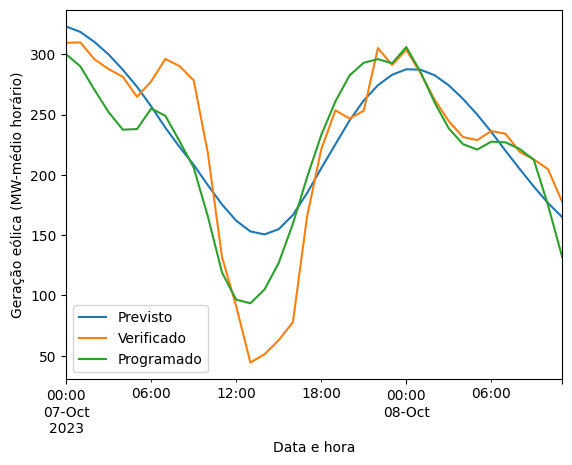

RMSE da previsão: 43.10963006038203; RMSE da programação: 34.70315100246662

Previsão da geração eólica de 36 horas a partir de 2023-10-8


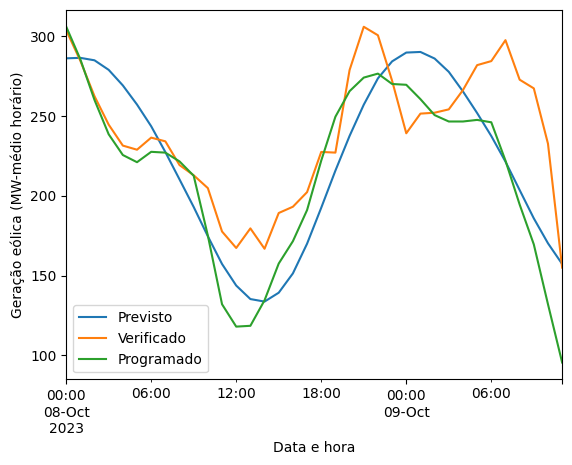

RMSE da previsão: 37.74232761174448; RMSE da programação: 38.53147583650137

Previsão da geração eólica de 36 horas a partir de 2023-10-9


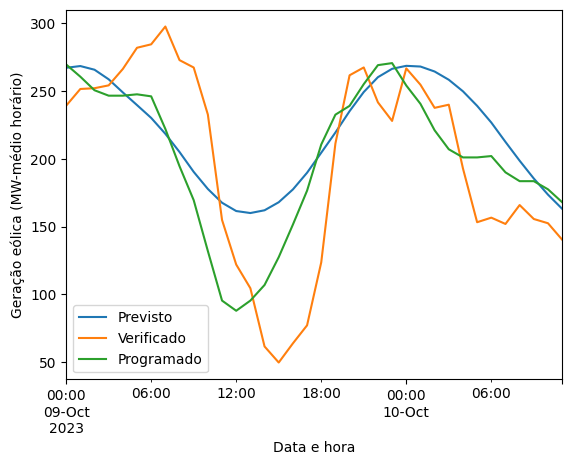

RMSE da previsão: 56.05644359574483; RMSE da programação: 49.21615803016322

Previsão da geração eólica de 36 horas a partir de 2023-10-10


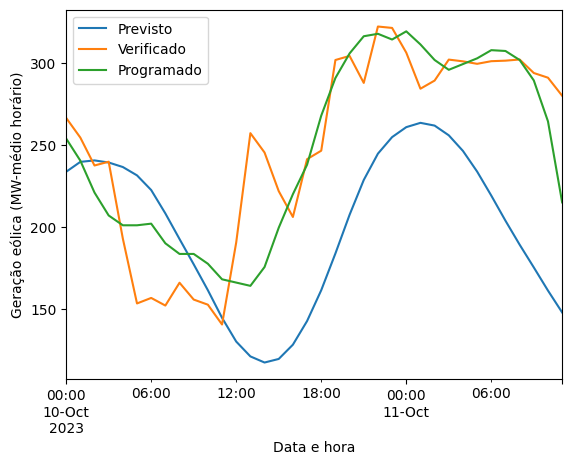

RMSE da previsão: 77.87277088468244; RMSE da programação: 30.080591908792837

Previsão da geração eólica de 36 horas a partir de 2023-10-11


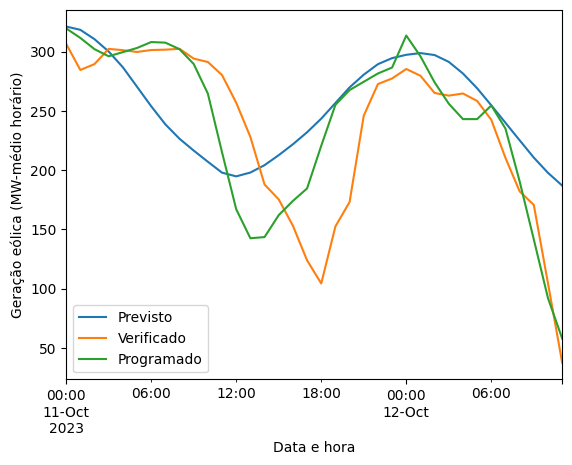

RMSE da previsão: 61.68903123327985; RMSE da programação: 42.76460599705478

Previsão da geração eólica de 36 horas a partir de 2023-10-12


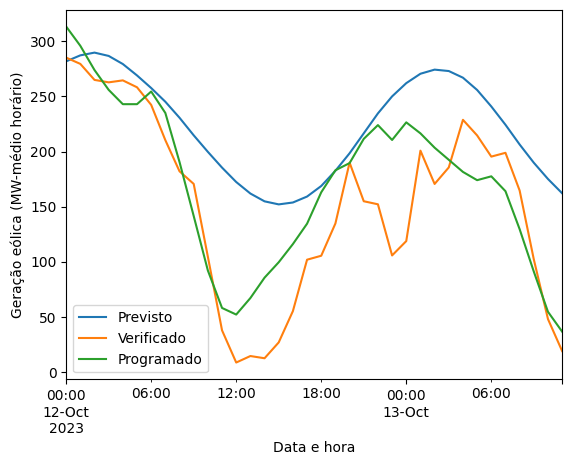

RMSE da previsão: 86.53985407639168; RMSE da programação: 43.89835674063184

Previsão da geração eólica de 36 horas a partir de 2023-10-13


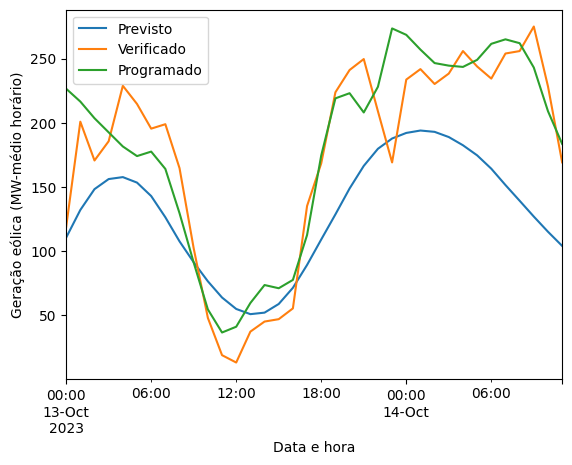

RMSE da previsão: 64.34901843879703; RMSE da programação: 34.00471773028953


RMSE médio da previsão: 61.05129655728891
RMSE médio da programação: 39.02843674941431


In [21]:
random.seed(23) # inicializando o gerador de números pseudo-aleatórios com uma "semente" para que os resultados sejam os mesmos para cada vez que este código for executado

model_1 = MultiOutputRegressor(Ridge(alpha=0.0001))

model_1.fit(X_train_transformed, y_train_transformed)

rmse_pred_train=[]  
rmse_pred_test=[]
rmse_prog=[]

# Estimação do desempenho do modelo de predição quando aplicado ao conjunto de teste
for cutoff_date in cutoff_dates:
    print(f"Previsão da geração eólica de {forecast_horizon} horas a partir de {cutoff_date}")
    forecasted_values, rmse_predicted_test, rmse_baseline = make_forecast_wind_generation(
        model=model_1, X=X_test, y=y_test, 
        target_variables=target_variables, 
        forecast_point_start=cutoff_date,
        forecast_horizon=forecast_horizon, pipeline=pipeline, baseline=baseline)
    
    print(f"RMSE da previsão: {rmse_predicted_test}; RMSE da programação: {rmse_baseline}\n")
    rmse_pred_test.append(rmse_predicted_test)
    rmse_prog.append(rmse_baseline)

print(f"\nRMSE médio da previsão: {mean(rmse_pred_test)}")
print(f"RMSE médio da programação: {mean(rmse_prog)}")

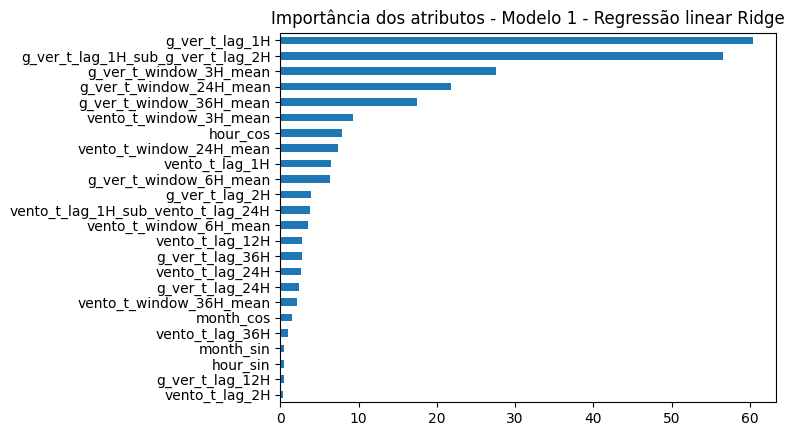

In [22]:
feature_importances = pd.Series(np.abs(model_1.estimators_[1].coef_))
feature_importances.index = X_train_transformed.columns
feature_importances = feature_importances.sort_values()
feature_importances.plot.barh(title="Importância dos atributos - Modelo 1 - Regressão linear Ridge");

### Modelo 2 - Floresta aleatória

Hiperparâmetros selecionados para a floresta aleatória:
- Número de estimadores: 100
- Profundidade máxima da árvore: não limitada
- Número mínimo de amostras por folha: 1

(Nota: estes são os hiperparâmetros padrão do regressor de floresta aleatória do _scikit-learn_)

Previsão da geração eólica de 36 horas a partir de 2023-10-7


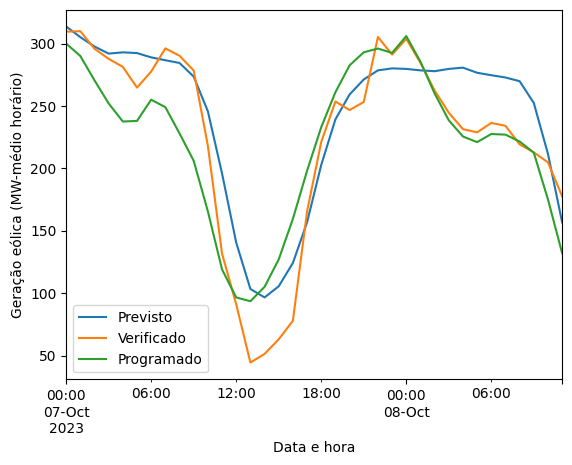

RMSE da previsão: 30.89053806929179; RMSE da programação: 34.70315100246662

Previsão da geração eólica de 36 horas a partir de 2023-10-8


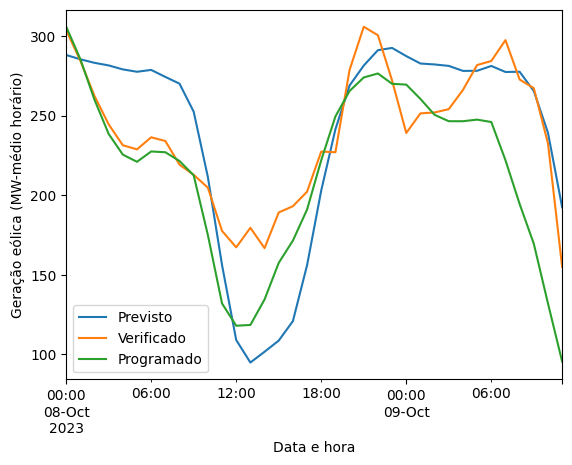

RMSE da previsão: 38.15351436838263; RMSE da programação: 38.53147583650137

Previsão da geração eólica de 36 horas a partir de 2023-10-9


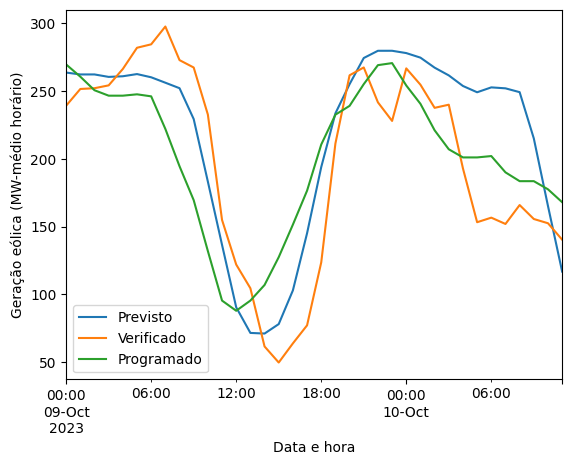

RMSE da previsão: 44.73308209837117; RMSE da programação: 49.21615803016322

Previsão da geração eólica de 36 horas a partir de 2023-10-10


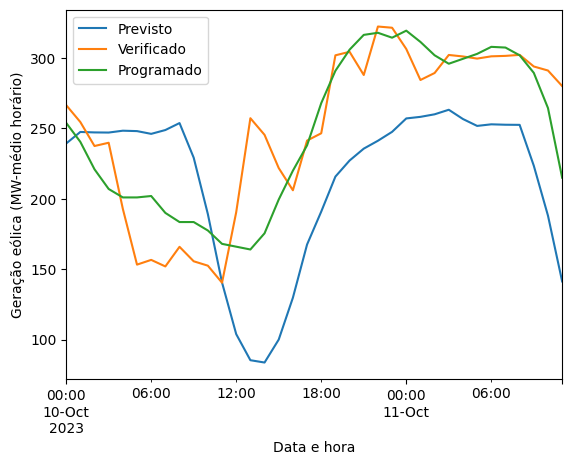

RMSE da previsão: 77.72323278508244; RMSE da programação: 30.080591908792837

Previsão da geração eólica de 36 horas a partir de 2023-10-11


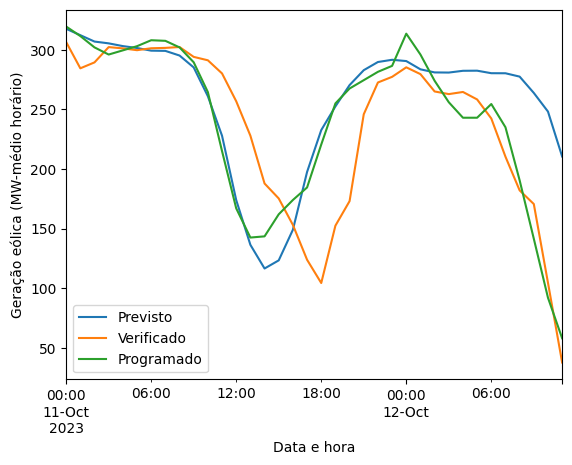

RMSE da previsão: 63.98936554238758; RMSE da programação: 42.76460599705478

Previsão da geração eólica de 36 horas a partir de 2023-10-12


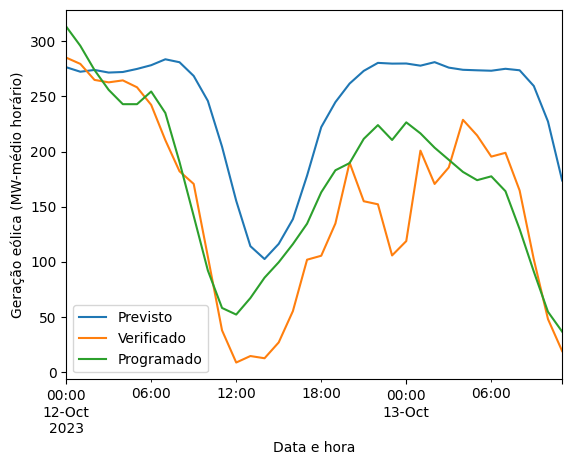

RMSE da previsão: 104.00437641977165; RMSE da programação: 43.89835674063184

Previsão da geração eólica de 36 horas a partir de 2023-10-13


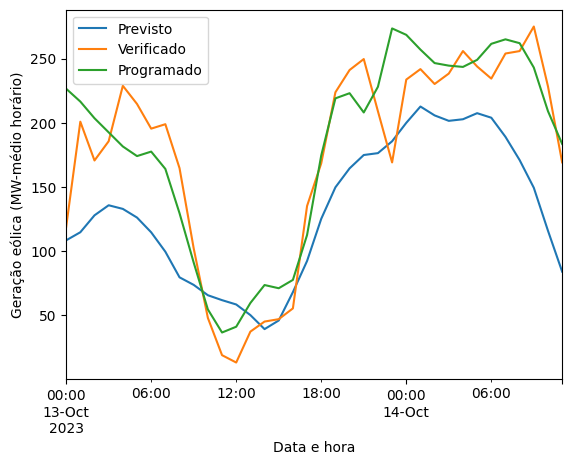

RMSE da previsão: 61.482341560795426; RMSE da programação: 34.00471773028953


RMSE médio da previsão: 60.1394929777261
RMSE médio da programação: 39.02843674941431


In [23]:
random.seed(23) # inicializando o gerador de números pseudo-aleatórios com uma "semente" para que os resultados sejam os mesmos para cada vez que este código for executado


model_2 = MultiOutputRegressor(RandomForestRegressor(n_jobs = -1,
                                                     random_state = 23,
                                                     n_estimators = 100,
                                                     max_depth = None,
                                                     min_samples_leaf = 1
                                            ))

model_2.fit(X_train_transformed, y_train_transformed)

rmse_pred_train=[]  
rmse_pred_test=[]
rmse_prog=[]

# Estimação do desempenho do modelo de predição quando aplicado ao conjunto de teste
for cutoff_date in cutoff_dates:
    print(f"Previsão da geração eólica de {forecast_horizon} horas a partir de {cutoff_date}")
    forecasted_values, rmse_predicted_test, rmse_baseline = make_forecast_wind_generation(
        model=model_2, X=X_test, y=y_test, 
        target_variables=target_variables, 
        forecast_point_start=cutoff_date,
        forecast_horizon=forecast_horizon, pipeline=pipeline, baseline=baseline)
    
    print(f"RMSE da previsão: {rmse_predicted_test}; RMSE da programação: {rmse_baseline}\n")
    rmse_pred_test.append(rmse_predicted_test)
    rmse_prog.append(rmse_baseline)

print(f"\nRMSE médio da previsão: {mean(rmse_pred_test)}")
print(f"RMSE médio da programação: {mean(rmse_prog)}")

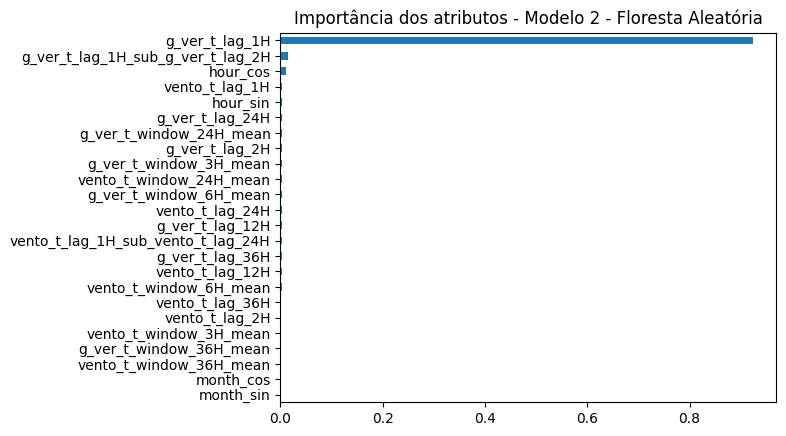

In [24]:
feature_importances = pd.Series(np.abs(model_2.estimators_[1].feature_importances_))
feature_importances.index = X_train_transformed.columns
feature_importances = feature_importances.sort_values()
feature_importances.plot.barh(title="Importância dos atributos - Modelo 2 - Floresta Aleatória");

### Modelo 3 - Light Gradient Boosted Machine

Hiperparâmetros selecionados para o regressor Light GBM:
- Regularização L1: 0.0001
- Profundidade máxima de cada árvore: 9
- Número mínimo de registros por folha em cada árvore: 23
- Número de folhas em cada árvore: 256 

Previsão da geração eólica de 36 horas a partir de 2023-10-7


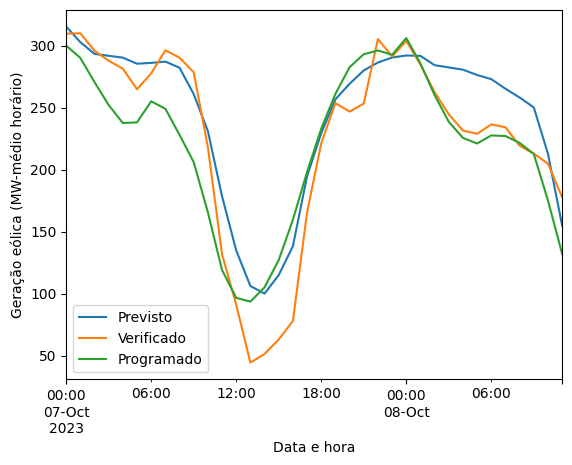

RMSE da previsão: 30.25668591186918; RMSE da programação: 34.70315100246662

Previsão da geração eólica de 36 horas a partir de 2023-10-8


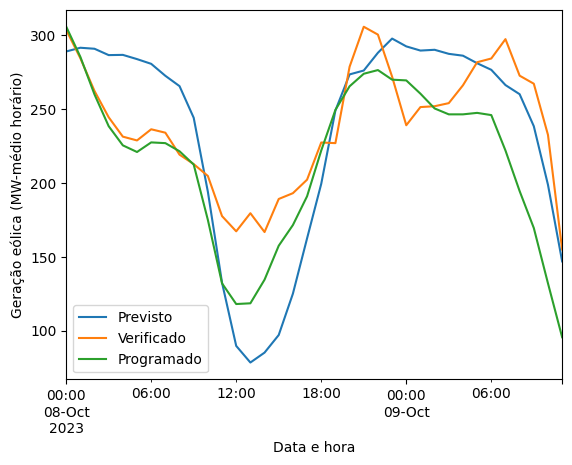

RMSE da previsão: 43.73333660525697; RMSE da programação: 38.53147583650137

Previsão da geração eólica de 36 horas a partir de 2023-10-9


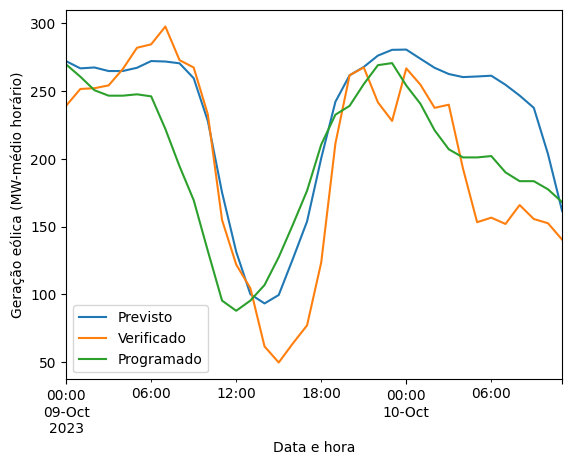

RMSE da previsão: 48.02979201573632; RMSE da programação: 49.21615803016322

Previsão da geração eólica de 36 horas a partir de 2023-10-10


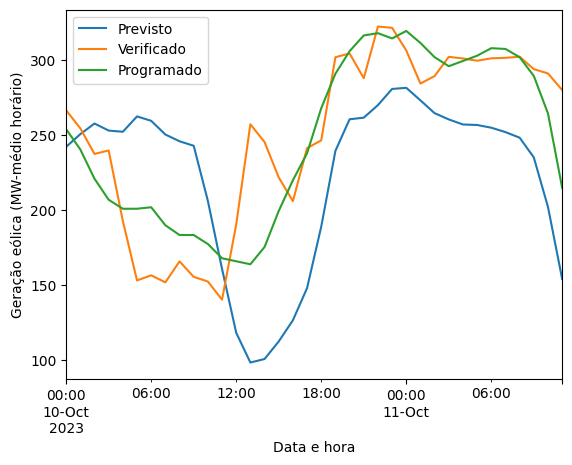

RMSE da previsão: 72.34479359200536; RMSE da programação: 30.080591908792837

Previsão da geração eólica de 36 horas a partir de 2023-10-11


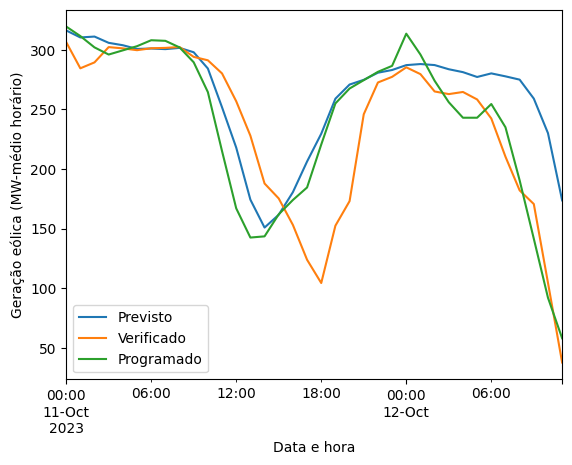

RMSE da previsão: 55.637690483769255; RMSE da programação: 42.76460599705478

Previsão da geração eólica de 36 horas a partir de 2023-10-12


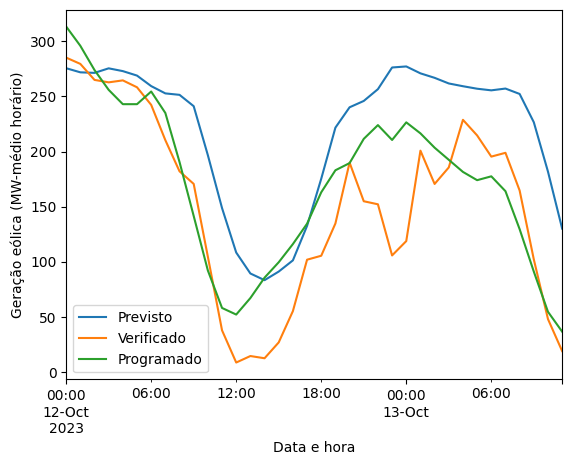

RMSE da previsão: 80.40574514851754; RMSE da programação: 43.89835674063184

Previsão da geração eólica de 36 horas a partir de 2023-10-13


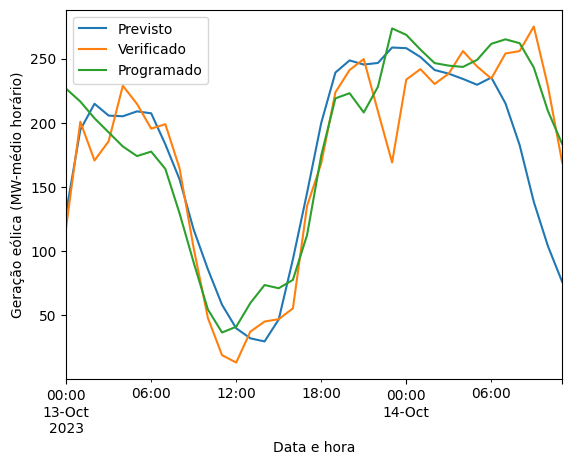

RMSE da previsão: 44.502520667479665; RMSE da programação: 34.00471773028953


RMSE médio da previsão: 53.55865206066204
RMSE médio da programação: 39.02843674941431


In [25]:
random.seed(23) # inicializando o gerador de números pseudo-aleatórios com uma "semente" para que os resultados sejam os mesmos para cada vez que este código for executado


model_3 = MultiOutputRegressor(LGBMRegressor(boosting = "gbdt", 
                                             linear_tree=True, 
                                             lambda_l1=0.0001,
                                             max_depth = 9,
                                             min_data_in_leaf=23,
                                             num_leaves=256,
                                             verbose=-1
                                            ))

model_3.fit(X_train_transformed, y_train_transformed)

rmse_pred_train=[]  
rmse_pred_test=[]
rmse_prog=[]

# Estimação do desempenho do modelo de predição quando aplicado ao conjunto de teste
for cutoff_date in cutoff_dates:
    print(f"Previsão da geração eólica de {forecast_horizon} horas a partir de {cutoff_date}")
    forecasted_values, rmse_predicted_test, rmse_baseline = make_forecast_wind_generation(
        model=model_3, X=X_test, y=y_test, 
        target_variables=target_variables, 
        forecast_point_start=cutoff_date,
        forecast_horizon=forecast_horizon, pipeline=pipeline, baseline=baseline)
    
    print(f"RMSE da previsão: {rmse_predicted_test}; RMSE da programação: {rmse_baseline}\n")
    rmse_pred_test.append(rmse_predicted_test)
    rmse_prog.append(rmse_baseline)

print(f"\nRMSE médio da previsão: {mean(rmse_pred_test)}")
print(f"RMSE médio da programação: {mean(rmse_prog)}")

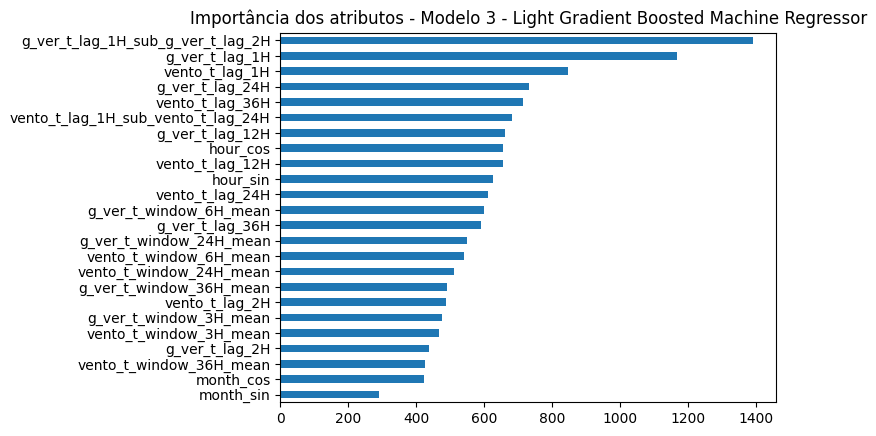

In [26]:
feature_importances = pd.Series(np.abs(model_3.estimators_[1].feature_importances_))
feature_importances.index = X_train_transformed.columns
feature_importances = feature_importances.sort_values()
feature_importances.plot.barh(title="Importância dos atributos - Modelo 3 - Light Gradient Boosted Machine Regressor");

### Modelo 4 - Extreme Gradient Boosted Machine

Hiperparâmetros selecionados para o regressor XGBoost:
- Taxa de aprendizagem: 0.12
- Número de estimadores: 247
- Profundidade máxima de cada estimador: 6
- Peso mínimo de cada nó filho: 7
- Regularização L2: 0.038
- Taxa de amostragem em cada estimador: 0.7

Previsão da geração eólica de 36 horas a partir de 2023-10-7


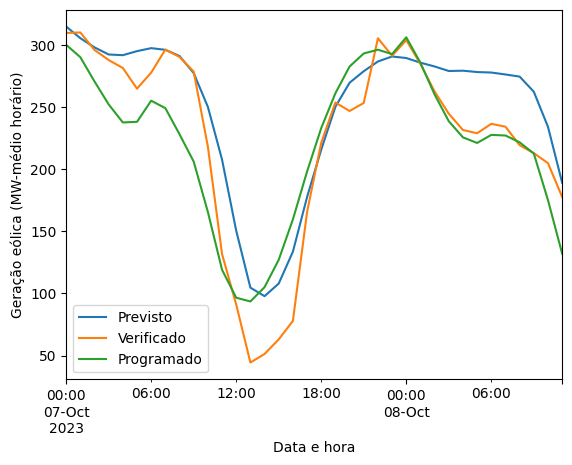

RMSE da previsão: 33.68392629820309; RMSE da programação: 34.70315100246662

Previsão da geração eólica de 36 horas a partir de 2023-10-8


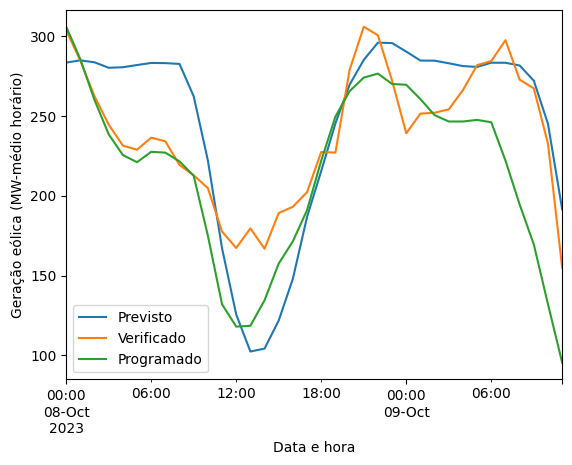

RMSE da previsão: 35.915369925568505; RMSE da programação: 38.53147583650137

Previsão da geração eólica de 36 horas a partir de 2023-10-9


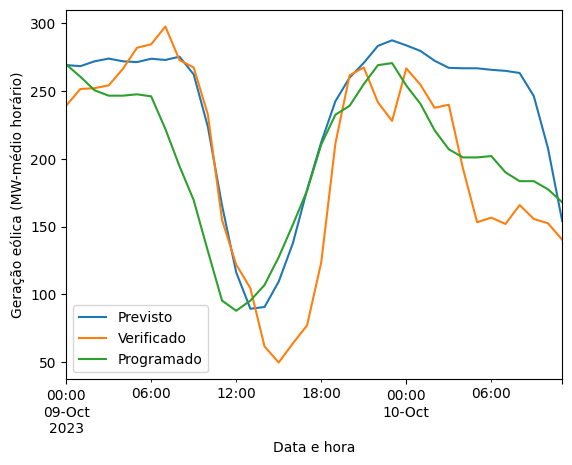

RMSE da previsão: 53.7262601439759; RMSE da programação: 49.21615803016322

Previsão da geração eólica de 36 horas a partir de 2023-10-10


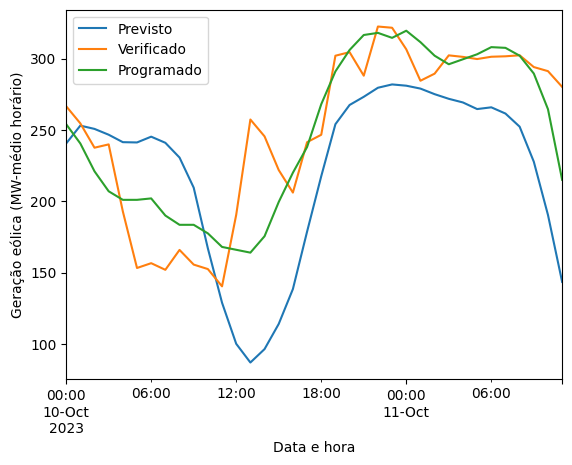

RMSE da previsão: 67.60821627013306; RMSE da programação: 30.080591908792837

Previsão da geração eólica de 36 horas a partir de 2023-10-11


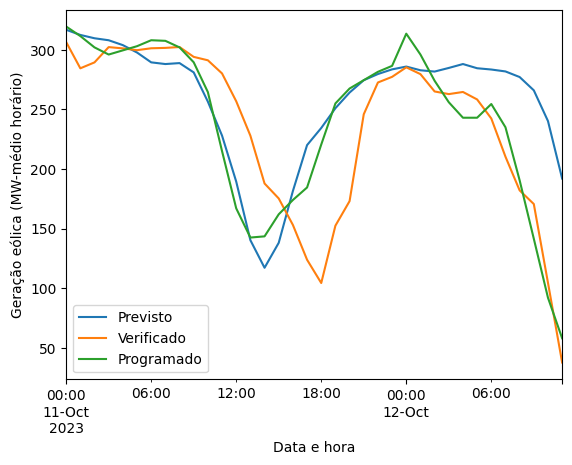

RMSE da previsão: 62.26465994356493; RMSE da programação: 42.76460599705478

Previsão da geração eólica de 36 horas a partir de 2023-10-12


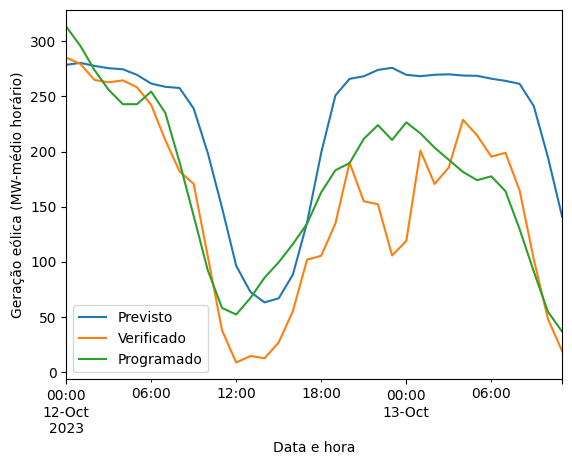

RMSE da previsão: 85.07886287490236; RMSE da programação: 43.89835674063184

Previsão da geração eólica de 36 horas a partir de 2023-10-13


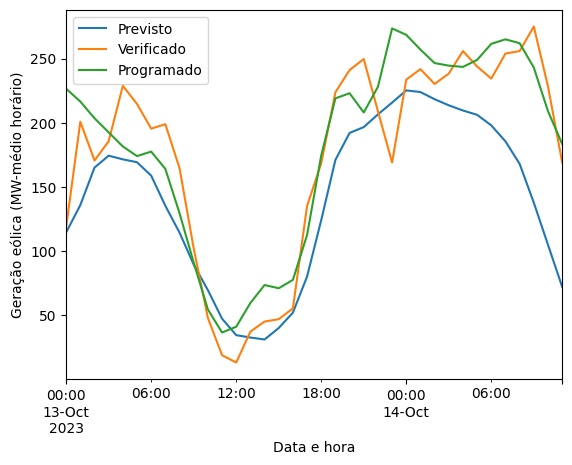

RMSE da previsão: 51.89147921067223; RMSE da programação: 34.00471773028953


RMSE médio da previsão: 55.738396381002865
RMSE médio da programação: 39.02843674941431


In [27]:
random.seed(23) # inicializando o gerador de números pseudo-aleatórios com uma "semente" para que os resultados sejam os mesmos para cada vez que este código for executado


model_4 = MultiOutputRegressor(XGBRegressor(verbosity = 0, silent=True,
                                           eta=0.12,
                                           n_estimators=247,
                                           max_depth=6,
                                           min_child_weight=7,
                                           reg_lambda=0.038,
                                           subsample=0.7))

model_4.fit(X_train_transformed, y_train_transformed)

rmse_pred_train=[]  
rmse_pred_test=[]
rmse_prog=[]

# Estimação do desempenho do modelo de predição quando aplicado ao conjunto de teste
for cutoff_date in cutoff_dates:
    print(f"Previsão da geração eólica de {forecast_horizon} horas a partir de {cutoff_date}")
    forecasted_values, rmse_predicted_test, rmse_baseline = make_forecast_wind_generation(
        model=model_4, X=X_test, y=y_test, 
        target_variables=target_variables, 
        forecast_point_start=cutoff_date,
        forecast_horizon=forecast_horizon, pipeline=pipeline, baseline=baseline)
    
    print(f"RMSE da previsão: {rmse_predicted_test}; RMSE da programação: {rmse_baseline}\n")
    rmse_pred_test.append(rmse_predicted_test)
    rmse_prog.append(rmse_baseline)

print(f"\nRMSE médio da previsão: {mean(rmse_pred_test)}")
print(f"RMSE médio da programação: {mean(rmse_prog)}")


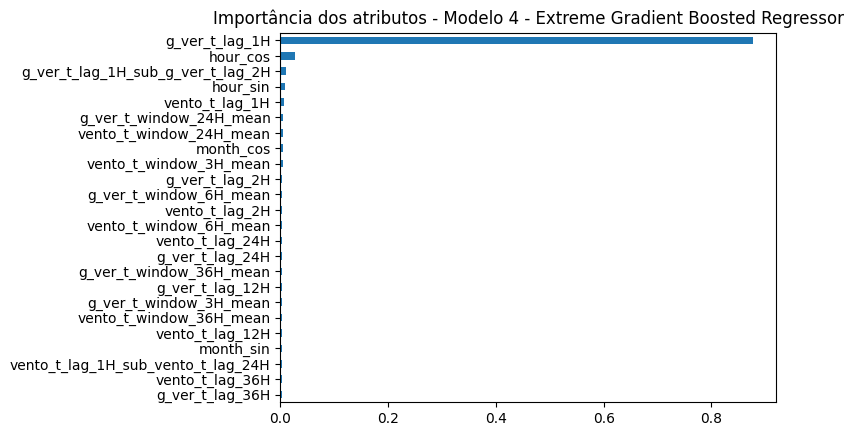

In [28]:
feature_importances = pd.Series(np.abs(model_4.estimators_[1].feature_importances_))
feature_importances.index = X_train_transformed.columns
feature_importances = feature_importances.sort_values()
feature_importances.plot.barh(title="Importância dos atributos - Modelo 4 - Extreme Gradient Boosted Regressor");

## Avaliação dos resultados

Programação do ONS
- RMSE: 39.028 MW-médio horário

Regressor linear Ridge
- RMSE: 61.051 MW-médio horário


Regressor Floresta Aleatória
- RMSE: 60.139 MW-médio horário


Regressor Light Gradient Boosted Machine
- RMSE: 53.558 MW-médio horário


Regressor Extreme Gradient Boosted
- RMSE: 55.738 MW-médio horário